# Dissecting PubMed
## Which content is covered by the Library? and Open Access?
#### Floriane Muller & Pablo Iriarte, Geneva University Library, Switzerland


# Merging PubMed with Crossref metadata

## 1. Metadata downloads from Crossref

Data was retrieved via the [Crossref's Works API](https://api.crossref.org/works) ([doc](https://github.com/CrossRef/rest-api-doc)) using the "[datacapsule](https://github.com/elifesciences/datacapsule-crossref/tree/analysis)" tool of I4OC

We downloaded the complete database on 2017-12-19, it took 16 days with a lot of interruptions. The result is a 44 Gb zip file grouping many json files of around 100 Mb each one (92832 files, 258606802513 bytes uncompressed, 45092238653 bytes compressed, 82.6% compression rate).

**Total number of DOIs in the first dump downloaded was 92826389**

To include all the 2017 data we completed this export with a new one made on 2018-02-01 keeping only metadata for publications after 2015. We modifiied the datacapsule code and replaced the query 'http://api.crossref.org/works?rows={}' (line 171 of "download_works.py") by this new query :
https://api.crossref.org/works?filter=from-pub-date:2015-01-01&mailto=pablo.iriarte@unige.ch&rows={}
The new export was downloaded quicker and with no interruption (thanks to the inclusion of email as key in the URL?) and represents a 12.8 Gb zip file containing 13145 json files around 100Mb each one.

**Total number of DOIs in the second dump downloaded (publications after 2015) was 13079699**


## 2. Metadata extraction from Crossref

We modified the datacapsule code (extract_metadata_from_works.py) to extract only the fields required for the first analysis : 

 * doi
 * volume
 * issue
 * page
 * article_number
 * issued
 * ISSN
 * container_title
 * type
 * alternative_id
 
The result is a 10.9 Gb TSV file that we imported into SQLite database to test the possibilites to merge the data. We decided to test those two combinations of metadata as keys to merge PubMed and Crossref data:

1. first author name + start page + publication date ("APD" as nickname)
2. volume + issue + pages + issnl + publication date ("VIPID" as nickname)

### 3.1 APD method

We extract these fields from Crossref for the merge:

  * doi
  * author
  * page
  * article-number
  * issued
  * published-print
  
Result head for the first dump:
```csv
doi|author|page|article-number|issued|published-print
10.1002/(sici)1096-8628(19960102)61:1<10::aid-ajmg2>3.0.co;2-0|[{'given': 'Katherine M.', 'family': 'Hegmann', 'affiliation': []}, {'given': 'Aimee S.', 'family': 'Spikes', 'affiliation': []}, {'given': 'Avi', 'family': 'Orr-Urtreger', 'affiliation': []}, {'given': 'Lisa G.', 'family': 'Shaffer', 'affiliation': []}]|10-15||[[1996, 1, 2]]|[[1996, 1, 2]]
```

Result head for the last dump (publications after 2015):
```csv
doi|author|page|article-number|issued|published-print
10.1001/jama.2014.16376|[{'given': 'Christopher J. L.', 'family': 'Murray', 'affiliation': [{'name': 'Institute for Health Metrics and Evaluation, Seattle, Washington'}]}]|359||[[2015, 1, 27]]|[[2015, 1, 27]]
```

We keep only the rows with issued date < 2015 of the first dump and append the second dump in order to have a single dataframe for Crossref


### 3.2 VIPID method

This method was abandoned because we haven't not enough time to implement-it and it was more similar than EU PMC method

In [1]:
# read first dump using Dask library (http://dask.pydata.org)
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import unidecode
import pandas as pd

df1 = dd.read_csv('F:\data_sources\crossref\crossref_extractions\doi_vipid\data_all_20171219\crossref-works-metadata.tsv', sep='|', header=0, usecols=['doi', 'issued'], encoding='utf-8', blocksize=5e6)
df1

,doi,issued
npartitions=2246,,
,object,object
,...,...
...,...,...
,...,...
,...,...


In [2]:
df1.head(10)

,doi,issued
0,10.1002/(sici)1096-8628(19960102)61:1<10::aid-...,"[[1996, 1, 2]]"
1,10.1002/(sici)1096-8628(19960102)61:1<2::aid-a...,"[[1996, 1, 2]]"
2,10.1002/(sici)1096-8628(19960102)61:1<37::aid-...,"[[1996, 1, 2]]"
3,10.1002/(sici)1096-8628(19960102)61:1<45::aid-...,"[[1996, 1, 2]]"
4,10.1002/(sici)1096-8628(19960102)61:1<68::aid-...,"[[1996, 1, 2]]"
5,10.1002/(sici)1096-8628(19960102)61:1<75::aid-...,"[[1996, 1, 2]]"
6,10.1002/(sici)1096-8628(19960102)61:1<79::aid-...,"[[1996, 1, 2]]"
7,10.1002/(sici)1096-8628(19960111)61:2<111::aid...,"[[1996, 1, 11]]"
8,10.1002/(sici)1096-8628(19960111)61:2<122::aid...,"[[1996, 1, 11]]"
9,10.1002/(sici)1096-8628(19960111)61:2<131::aid...,"[[1996, 1, 11]]"


In [ ]:
# keep data with issued < 2015
with ProgressBar():
    df = df1.loc[df1.issued < 2015]
df

In [ ]:
# read second dump (data after 2015)
df2 = dd.read_csv('data/sources/crossref/crossref-works-metadata-after-2015.tsv', sep='|', dtype={'article-number': 'object', 'issued': 'float64', 'published-print': 'float64','author': 'object'}, encoding='utf-8', blocksize=5e6)
df2

In [ ]:
df2.head(10)

In [ ]:
df = df.append(df2)
df

In [ ]:
df.head(10)

In [ ]:
df.tail(10)

In [9]:
# reset index
df = df.reset_index()

In [9]:
# test rows with published-print not equal to issued
with ProgressBar():
    mycrossref_published_print = df.loc[(df['published-print'] > 0) & (df['published-print'] > df['issued']) | (df['published-print'] < df['issued'])].compute()
mycrossref_published_print

[################################        ] | 81% Completed |  1min 57.3s

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\local.py:290: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


[########################################] | 100% Completed |  2min 25.5s


,doi,author,page,article-number,issued,published-print
1088,10.1002/(sici)1096-8628(19991229)89:4<224::aid...,Simpson,224,NaN,2000.0,0
4927,10.1002/(sici)1096-9861(19990607)408:3<437::ai...,Richter,437,NaN,1999.0,0
9808,10.1002/(sici)1097-0142(19970215)79:4<813::aid...,Modlin,813,NaN,2000.0,0
10989,10.1002/(sici)1097-0169(1998)40:2<193::aid-cm8...,Ehler,193,NaN,1998.0,0
14669,10.1002/(sici)1097-0258(20000229)19:4<617::aid...,Slate,617,NaN,2000.0,0
15197,10.1002/(sici)1097-0282(199602)38:2<131::aid-b...,Tuzikov,131,NaN,1998.0,0
15198,10.1002/(sici)1097-0282(199602)38:2<141::aid-b...,Shenderovich,141,NaN,1998.0,0
15199,10.1002/(sici)1097-0282(199602)38:2<157::aid-b...,Liwo,157,NaN,1998.0,0
15201,10.1002/(sici)1097-0282(199602)38:2<251::aid-b...,Levy,251,NaN,1998.0,0
15202,10.1002/(sici)1097-0282(199603)38:3<301::aid-b...,Formaggio,301,NaN,1998.0,0


In [11]:
mycrossref_published_print = mycrossref_published_print.loc[(mycrossref_published_print['published-print'] > 0)]
mycrossref_published_print

,doi,author,page,article-number,issued,published-print
34785,10.1002/(sici)1098-2345(200001)50:1<53::aid-aj...,Wong,53,NaN,1999.0,2000
34786,10.1002/(sici)1098-2345(200001)50:1<67::aid-aj...,Maggioncalda,67,NaN,1999.0,2000
34787,10.1002/(sici)1098-2345(200001)50:1<87::aid-aj...,Westergaard,87,NaN,1999.0,2000
34788,10.1002/(sici)1098-2345(200001)50:1<9::aid-ajp...,Mutschler,9,NaN,1999.0,2000
10699,10.1002/1096-9845(200101)30:1<115::aid-eqe999>...,Paglietti,115,NaN,2000.0,2001
10700,10.1002/1096-9845(200101)30:1<127::aid-eqe2>3....,Archer,127,NaN,2000.0,2001
10701,10.1002/1096-9845(200101)30:1<1::aid-eqe991>3....,Choi,1,NaN,2000.0,2001
10702,10.1002/1096-9845(200101)30:1<43::aid-eqe994>3...,Wegner,43,NaN,2000.0,2001
10703,10.1002/1096-9845(200101)30:1<59::aid-eqe996>3...,Wang,59,NaN,2000.0,2001
10704,10.1002/1096-9845(200101)30:1<97::aid-eqe998>3...,Hadid,97,NaN,2000.0,2001


In [12]:
mycrossref_published_print.loc[mycrossref_published_print['published-print'] < mycrossref_published_print['issued']]

,doi,author,page,article-number,issued,published-print


In [13]:
mycrossref_published_print.loc[mycrossref_published_print['published-print'] == mycrossref_published_print['issued']]

,doi,author,page,article-number,issued,published-print


In [14]:
mycrossref_published_print.loc[mycrossref_published_print['published-print'] > mycrossref_published_print['issued']]

,doi,author,page,article-number,issued,published-print
34785,10.1002/(sici)1098-2345(200001)50:1<53::aid-aj...,Wong,53,NaN,1999.0,2000
34786,10.1002/(sici)1098-2345(200001)50:1<67::aid-aj...,Maggioncalda,67,NaN,1999.0,2000
34787,10.1002/(sici)1098-2345(200001)50:1<87::aid-aj...,Westergaard,87,NaN,1999.0,2000
34788,10.1002/(sici)1098-2345(200001)50:1<9::aid-ajp...,Mutschler,9,NaN,1999.0,2000
10699,10.1002/1096-9845(200101)30:1<115::aid-eqe999>...,Paglietti,115,NaN,2000.0,2001
10700,10.1002/1096-9845(200101)30:1<127::aid-eqe2>3....,Archer,127,NaN,2000.0,2001
10701,10.1002/1096-9845(200101)30:1<1::aid-eqe991>3....,Choi,1,NaN,2000.0,2001
10702,10.1002/1096-9845(200101)30:1<43::aid-eqe994>3...,Wegner,43,NaN,2000.0,2001
10703,10.1002/1096-9845(200101)30:1<59::aid-eqe996>3...,Wang,59,NaN,2000.0,2001
10704,10.1002/1096-9845(200101)30:1<97::aid-eqe998>3...,Hadid,97,NaN,2000.0,2001


In [15]:
# use article number if page is empty
mycrossref_published_print.loc[(mycrossref_published_print['page'].isnull()) & (mycrossref_published_print['article-number'].notnull())]

,doi,author,page,article-number,issued,published-print
45978,10.1029/2005jc003134,Dorman,NaN,C03S03,2006.0,2007
45981,10.1029/2005jc003260,Polimene,NaN,C03S19,2006.0,2007
66233,10.1029/2005jc003177,Ursella,NaN,C03S04,2006.0,2007
95062,10.1029/2005jc003110,Wang,NaN,C03S17,2006.0,2007
42925,10.1029/2005je002657,Evans,NaN,E03S04,2006.0,2007
43027,10.1029/2006je002675,Karunatillake,NaN,E03S05,2006.0,2007
43145,10.1029/2006je002676,Taylor,NaN,E03S06,2006.0,2007
43182,10.1029/2006je002679,Keller,NaN,E03S08,2006.0,2007
52780,10.1029/2005je002655,Kim,NaN,E03S09,2006.0,2007
51241,10.1029/2005jc003271,Orlić,NaN,C03S07,2006.0,2007


In [18]:
mycrossref_published_print = mycrossref_published_print.reset_index()
mycrossref_published_print['spage'] = mycrossref_published_print['page']
mycrossref_published_print.loc[(mycrossref_published_print['page'].isnull()) & (mycrossref_published_print['article-number'].notnull()), ['spage']] = mycrossref_published_print['article-number']
mycrossref_published_print

,index,doi,author,page,article-number,issued,published-print,spage
0,34785,10.1002/(sici)1098-2345(200001)50:1<53::aid-aj...,Wong,53,NaN,1999.0,2000,53
1,34786,10.1002/(sici)1098-2345(200001)50:1<67::aid-aj...,Maggioncalda,67,NaN,1999.0,2000,67
2,34787,10.1002/(sici)1098-2345(200001)50:1<87::aid-aj...,Westergaard,87,NaN,1999.0,2000,87
3,34788,10.1002/(sici)1098-2345(200001)50:1<9::aid-ajp...,Mutschler,9,NaN,1999.0,2000,9
4,10699,10.1002/1096-9845(200101)30:1<115::aid-eqe999>...,Paglietti,115,NaN,2000.0,2001,115
5,10700,10.1002/1096-9845(200101)30:1<127::aid-eqe2>3....,Archer,127,NaN,2000.0,2001,127
6,10701,10.1002/1096-9845(200101)30:1<1::aid-eqe991>3....,Choi,1,NaN,2000.0,2001,1
7,10702,10.1002/1096-9845(200101)30:1<43::aid-eqe994>3...,Wegner,43,NaN,2000.0,2001,43
8,10703,10.1002/1096-9845(200101)30:1<59::aid-eqe996>3...,Wang,59,NaN,2000.0,2001,59
9,10704,10.1002/1096-9845(200101)30:1<97::aid-eqe998>3...,Hadid,97,NaN,2000.0,2001,97


In [19]:
mycrossref_published_print.loc[(mycrossref_published_print['page'].isnull()) & (mycrossref_published_print['article-number'].notnull())]

,index,doi,author,page,article-number,issued,published-print,spage
43957,45978,10.1029/2005jc003134,Dorman,NaN,C03S03,2006.0,2007,C03S03
43958,45981,10.1029/2005jc003260,Polimene,NaN,C03S19,2006.0,2007,C03S19
44407,66233,10.1029/2005jc003177,Ursella,NaN,C03S04,2006.0,2007,C03S04
59297,95062,10.1029/2005jc003110,Wang,NaN,C03S17,2006.0,2007,C03S17
60663,42925,10.1029/2005je002657,Evans,NaN,E03S04,2006.0,2007,E03S04
60664,43027,10.1029/2006je002675,Karunatillake,NaN,E03S05,2006.0,2007,E03S05
60666,43145,10.1029/2006je002676,Taylor,NaN,E03S06,2006.0,2007,E03S06
60668,43182,10.1029/2006je002679,Keller,NaN,E03S08,2006.0,2007,E03S08
60785,52780,10.1029/2005je002655,Kim,NaN,E03S09,2006.0,2007,E03S09
62473,51241,10.1029/2005jc003271,Orlić,NaN,C03S07,2006.0,2007,C03S07


In [20]:
# use published-print as year
mycrossref_published_print['year2'] = mycrossref_published_print['published-print']
mycrossref_published_print['spage2'] = mycrossref_published_print['spage']
mycrossref_published_print = mycrossref_published_print.dropna(subset=['author', 'year2', 'spage2'])
mycrossref_published_print

,index,doi,author,page,article-number,issued,published-print,spage,year2,spage2
0,34785,10.1002/(sici)1098-2345(200001)50:1<53::aid-aj...,Wong,53,NaN,1999.0,2000,53,2000,53
1,34786,10.1002/(sici)1098-2345(200001)50:1<67::aid-aj...,Maggioncalda,67,NaN,1999.0,2000,67,2000,67
2,34787,10.1002/(sici)1098-2345(200001)50:1<87::aid-aj...,Westergaard,87,NaN,1999.0,2000,87,2000,87
3,34788,10.1002/(sici)1098-2345(200001)50:1<9::aid-ajp...,Mutschler,9,NaN,1999.0,2000,9,2000,9
4,10699,10.1002/1096-9845(200101)30:1<115::aid-eqe999>...,Paglietti,115,NaN,2000.0,2001,115,2001,115
5,10700,10.1002/1096-9845(200101)30:1<127::aid-eqe2>3....,Archer,127,NaN,2000.0,2001,127,2001,127
6,10701,10.1002/1096-9845(200101)30:1<1::aid-eqe991>3....,Choi,1,NaN,2000.0,2001,1,2001,1
7,10702,10.1002/1096-9845(200101)30:1<43::aid-eqe994>3...,Wegner,43,NaN,2000.0,2001,43,2001,43
8,10703,10.1002/1096-9845(200101)30:1<59::aid-eqe996>3...,Wang,59,NaN,2000.0,2001,59,2001,59
9,10704,10.1002/1096-9845(200101)30:1<97::aid-eqe998>3...,Hadid,97,NaN,2000.0,2001,97,2001,97


In [10]:
# use issued as year and replace by published-print when exists
df['year'] = df['published-print'].where(df['published-print'] > df['issued'], df['issued'])

In [11]:
with ProgressBar():
    mycrossref_published_print2 = df.loc[(df['published-print'] >  df['issued'])].compute()
mycrossref_published_print2

[################################        ] | 81% Completed |  2min  3.3s

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\local.py:290: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


[########################################] | 100% Completed |  2min 34.3s


,index,doi,author,page,article-number,issued,published-print,year
34785,34785,10.1002/(sici)1098-2345(200001)50:1<53::aid-aj...,Wong,53,NaN,1999.0,2000.0,2000.0
34786,34786,10.1002/(sici)1098-2345(200001)50:1<67::aid-aj...,Maggioncalda,67,NaN,1999.0,2000.0,2000.0
34787,34787,10.1002/(sici)1098-2345(200001)50:1<87::aid-aj...,Westergaard,87,NaN,1999.0,2000.0,2000.0
34788,34788,10.1002/(sici)1098-2345(200001)50:1<9::aid-ajp...,Mutschler,9,NaN,1999.0,2000.0,2000.0
10699,10699,10.1002/1096-9845(200101)30:1<115::aid-eqe999>...,Paglietti,115,NaN,2000.0,2001.0,2001.0
10700,10700,10.1002/1096-9845(200101)30:1<127::aid-eqe2>3....,Archer,127,NaN,2000.0,2001.0,2001.0
10701,10701,10.1002/1096-9845(200101)30:1<1::aid-eqe991>3....,Choi,1,NaN,2000.0,2001.0,2001.0
10702,10702,10.1002/1096-9845(200101)30:1<43::aid-eqe994>3...,Wegner,43,NaN,2000.0,2001.0,2001.0
10703,10703,10.1002/1096-9845(200101)30:1<59::aid-eqe996>3...,Wang,59,NaN,2000.0,2001.0,2001.0
10704,10704,10.1002/1096-9845(200101)30:1<97::aid-eqe998>3...,Hadid,97,NaN,2000.0,2001.0,2001.0


In [36]:
pd.set_option('max_colwidth',60)
mycrossref_published_print2.loc[mycrossref_published_print2['index'] == 10734]

,index,doi,author,page,article-number,issued,published-print,year
10734,10734,10.1002/1096-9861(20000101)429:1<144::aid-cne11>3.0.co;2-b,Gonz�lez-Mart�nez,144,NaN,2000.0,2001.0,2001.0
10555,10734,10.1107/s1600536804032015,Manivannan,o75,NaN,2004.0,2005.0,2005.0
8884,10734,10.1007/s11103-007-9268-2,Hirano,259,NaN,2007.0,2008.0,2008.0
9674,10734,10.1007/978-3-642-03145-8_3,Vistad,49,NaN,2009.0,2010.0,2010.0
10054,10734,10.1007/s00780-010-0124-x,Chen,221,NaN,2010.0,2011.0,2011.0
8958,10734,10.1007/s00261-008-9483-6,Verma,118,NaN,2008.0,2010.0,2010.0
10043,10734,10.1007/978-3-658-03695-9_9,Dumbach,57,NaN,2013.0,2014.0,2014.0
9203,10734,10.1017/cbo9780511974243,Stroock,NaN,NaN,2009.0,2010.0,2010.0
10504,10734,10.1007/s10708-014-9570-x,Cheong,679,NaN,2014.0,2015.0,2015.0
8875,10734,10.1088/0953-8984/26/3/036002,Kelley,036002,NaN,2013.0,2014.0,2014.0


In [37]:
with ProgressBar():
    years_crossref = df['year'].compute()
years_crossref_count = years_crossref.value_counts()
years_crossref_count

[################################        ] | 81% Completed |  2min  3.5s

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\local.py:290: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


[########################################] | 100% Completed |  2min 34.2s


2017.0    4542157
2016.0    4263436
2015.0    4096182
2014.0    3749241
2013.0    3635896
2012.0    3358545
2011.0    3166727
2010.0    3153587
2009.0    2851750
2008.0    2609856
2007.0    2495367
2006.0    2233544
2005.0    2005968
2004.0    1955478
2003.0    1743119
2002.0    1624365
2000.0    1584281
2001.0    1573966
1999.0    1401276
1998.0    1369729
1997.0    1336715
1996.0    1289241
1995.0    1230196
1994.0    1151360
1993.0    1115660
1992.0    1076743
1991.0    1041191
1990.0    1017076
1989.0     973042
1988.0     922118
           ...   
1411.0          1
1409.0          1
1400.0          1
1506.0          1
1555.0          1
1643.0          1
1541.0          1
2200.0          1
2023.0          1
2102.0          1
1550.0          1
1549.0          1
2061.0          1
2075.0          1
2085.0          1
1544.0          1
1542.0          1
1536.0          1
1515.0          1
1535.0          1
2028.0          1
2090.0          1
1529.0          1
1528.0          1
1527.0    

In [38]:
# Export to CSV
myfileout = 'data/results/dois_by_issued_date.tsv'
years_crossref_count.sort_index(ascending=0).to_csv(myfileout, sep='\t', encoding='utf-8', index=True)

In [39]:
# check DOIs with false dates in the future
dois_future = df[df.year > 2018].compute()
dois_future

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\local.py:290: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


,index,doi,author,page,article-number,issued,published-print,year
85839,90088,10.1017/ccol052147471x,NaN,NaN,NaN,2011.0,2097.0,2097.0
26229,29599,10.1017/ccol0521447801,Hollis,NaN,NaN,2011.0,2094.0,2094.0
59135,65503,10.1017/ccol0521265142,Mas-Colell,NaN,NaN,2011.0,2085.0,2085.0
59138,65525,10.1017/ccol0521265967,Lancaster,NaN,NaN,2011.0,2090.0,2090.0
5815,5896,10.5673/sip.51.2.4,Štambuk,NaN,NaN,2013.0,2103.0,2103.0
5818,5899,10.5673/sip.51.2.7,Cifrić,NaN,NaN,2013.0,2103.0,2103.0
5826,5907,10.5673/sip.51.2.2,Puljiz,NaN,NaN,2013.0,2103.0,2103.0
5831,5912,10.5673/sip.51.2.9,Defilippis,NaN,NaN,2013.0,2103.0,2103.0
5845,5926,10.5673/sip.51.2.5,Petak,NaN,NaN,2013.0,2103.0,2103.0
5861,5942,10.5673/sip.51.2.1,Stipetić,NaN,NaN,2013.0,2103.0,2103.0


In [40]:
# export DOIs with false dates in the future
myfileout = 'data/results/dois_future_dates.tsv'
dois_future.sort_index(ascending=0).to_csv(myfileout, sep='\t', encoding='utf-8', index=False)

In [41]:
# check DOIs with weird dates in the past
# first journal Philosophical Transactions published in 1665
# after checking some DOIs we concluded there are OK, there are chpters from scanned books from Shakespeare and other authors
with ProgressBar():
    dois_past = df.loc[df.year < 1665].compute()
dois_past

[################################        ] | 81% Completed |  2min  8.8s

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\local.py:290: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


[########################################] | 100% Completed |  2min 40.3s


,index,doi,author,page,article-number,issued,published-print,year
2792,2792,10.1006/ageo.2001.0001,Panza,1,NaN,0.0,0.0,0.0
2793,2793,10.1006/ageo.2001.0002,Wawersik,97,NaN,0.0,0.0,0.0
2794,2794,10.1006/ahec.2001.0001,Sadekov,0,NaN,0.0,0.0,0.0
2795,2795,10.1006/ahec.2001.0002,D'Auria,0,NaN,0.0,0.0,0.0
2798,2798,10.1006/ahec.2001.0003,Aitken,0,NaN,0.0,0.0,0.0
2799,2799,10.1006/ahec.2001.0004,Sadimenko,0,NaN,0.0,0.0,0.0
2800,2800,10.1006/ahec.2001.0005,Belen'Kii,0,NaN,0.0,0.0,0.0
6593,6593,10.1006/appe.2000.0394,NaN,1,NaN,0.0,0.0,0.0
46837,46837,10.1006/icar.2000.6473,Simon-Miller,1,NaN,0.0,0.0,0.0
60174,60174,10.1006/jaer.2000.0716,Kapuinen,1,NaN,0.0,0.0,0.0


In [42]:
# export DOIs with dates before 1665
myfileout = 'data/results/dois_strange_past_dates.tsv'
dois_past.to_csv(myfileout, sep='\t', encoding='utf-8', index=True)

In [43]:
# export year counts
year_counts = pd.read_csv('data/results/dois_by_issued_date.tsv', sep='\t', header=None, names=(['year', 'count']))
year_counts = year_counts.set_index('year')
year_counts = year_counts.sort_index()
year_counts

,count
year,
0.0,1097
1400.0,1
1409.0,1
1411.0,1
1425.0,1
1451.0,1
1456.0,1
1459.0,1
1469.0,1


In [44]:
# remove false dates
year_counts = year_counts.loc[(year_counts.index > 0) & (year_counts.index < 2019)]
year_counts

,count
year,
1400.0,1
1409.0,1
1411.0,1
1425.0,1
1451.0,1
1456.0,1
1459.0,1
1469.0,1
1472.0,1


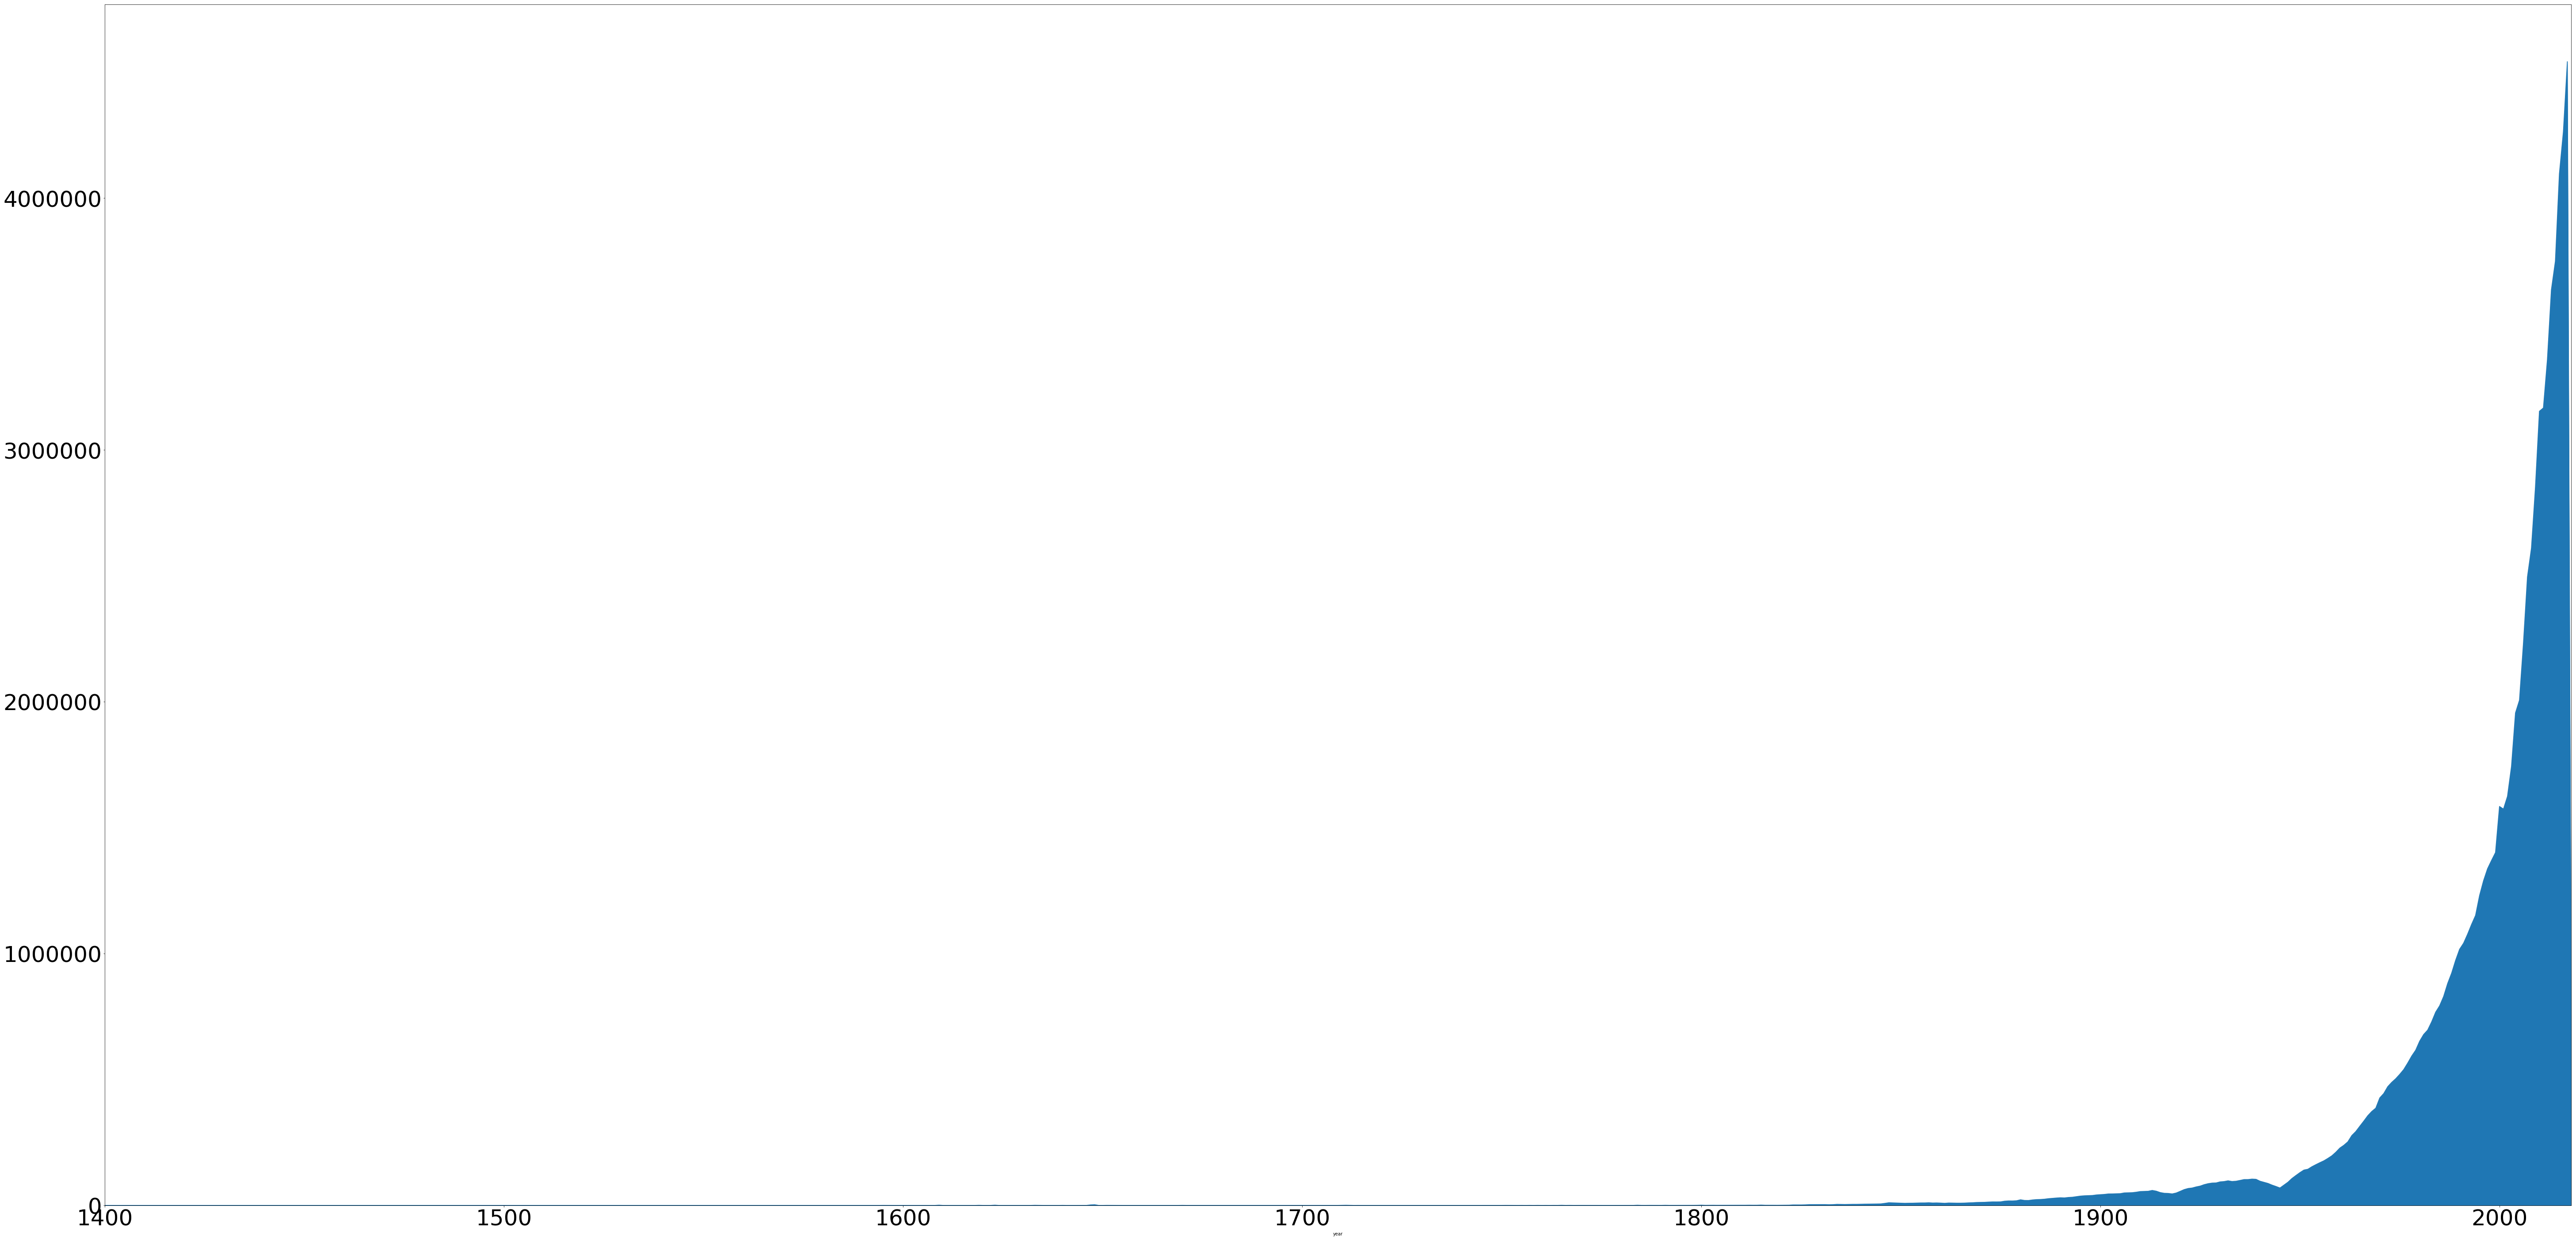

In [45]:
# plot year counts
import matplotlib.pyplot as plt  
%matplotlib inline
myfileoutfig = 'data/results/dois_all.png'
ax = year_counts.plot.area(fontsize=50, figsize=(100,50), legend=False)
fig = ax.get_figure()
fig.set_size_inches(100, 50)
fig.savefig(myfileoutfig, dpi=50)

## PubMed data extraction

We downloaded the complete XML metadata from https://www.nlm.nih.gov/databases/download/pubmed_medline.html

We extracted these fields from XML data usint XML starlet (http://xmlstar.sourceforge.net/):

 - PubmedArticleSet/PubmedArticle/MedlineCitation/PMID
 - PubmedArticleSet/PubmedArticle/MedlineCitation/Article/AuthorList/Author
 - PubmedArticleSet/PubmedArticle/MedlineCitation/Article/Journal/JournalIssue/PubDate/Year
 - PubmedArticleSet/PubmedArticle/MedlineCitation/Article/Journal/JournalIssue/PubDate/MedlineDate
 - PubmedArticleSet/PubmedArticle/MedlineCitation/Article/Pagination/MedlinePgn
 
 The result is 928 csv files: extraction_authors_year_page_pubmed18n[0001 - 0928].xml.gz.csv

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

df_pubmed = dd.read_csv('data/sources/pubmed/author_year_pages/*.csv', sep='|', names=('pmid', 'author', 'year', 'date', 'pages'), dtype={'pmid': 'int', 'author': 'str', 'year': 'str', 'date': 'str', 'pages': 'str'})
df_pubmed

,pmid,author,year,date,pages
npartitions=928,,,,,
,int32,object,object,object,object
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [2]:
df_pubmed.head(10)

,pmid,author,year,date,pages
0,2,Bose,1975,NaN,1173-9
1,1,Makar,1975,NaN,117-26
2,3,Smith,1975,NaN,1281-6
3,4,Wiesmann,1975,NaN,1338-43
4,6,Chow,1975,NaN,1424-31
5,7,Anderson,1975,NaN,1469-74
6,8,Moroi,1975,NaN,1517-21
7,5,Hendrickson,1975,NaN,1349-56
8,9,Marniemi,1975,NaN,1569-72
9,11,Lefkowitz,1975,NaN,1651-8


In [3]:
df_pubmed.tail(10)

,pmid,author,year,date,pages
27542,29172291,Sommaluan,2017,NaN,3135-3142
27543,29172292,Saraswathi,2017,NaN,3143-3148
27544,29172294,Palugulla,2017,NaN,3157-3165
27545,29172293,Tanriverdi,2017,NaN,3149-3155
27546,29172295,Mamdouh,2017,NaN,3167-3171
27547,29172298,Vicenty-Rivera,2016,NaN,43-6
27548,29172296,Okayama,2017,NaN,3173-3178
27549,29172299,Aquili,2017,NaN,NaN
27550,29172297,Rezaei,2017,NaN,3179-3185
27551,29172300,Bonicoli,2017,NaN,NaN


In [4]:
# check number of PMIDs
with ProgressBar():
    df_pubmed_pmids = df_pubmed['pmid'].compute()
myfileout = 'data/results/pmids_all.tsv'
df_pubmed_pmids.to_csv(myfileout, sep='\t', encoding='utf-8', index=False)
df_pubmed_pmids

[########################################] | 100% Completed | 34.9s


0               2
1               1
2               3
3               4
4               6
5               7
6               8
7               5
8               9
9              11
10             10
11             13
12             14
13             15
14             16
15             17
16             18
17             19
18             20
19             12
20             21
21             22
22             23
23             24
24             25
25             27
26             26
27             28
28             30
29             31
           ...   
27522    29172271
27523    29172272
27524    29172273
27525    29172274
27526    29172275
27527    29172276
27528    29172277
27529    29172278
27530    29172279
27531    29172280
27532    29172281
27533    29172282
27534    29172283
27535    29172284
27536    29172285
27537    29172286
27538    29172287
27539    29172288
27540    29172289
27541    29172290
27542    29172291
27543    29172292
27544    29172294
27545    29172293
27546    2

In [5]:
df_pubmed_pmids.shape

(27837540,)

In [6]:
with ProgressBar():
    df_pubmed_date_vide = df_pubmed.loc[df_pubmed.year.isnull()].compute()
myfileout = 'data/results/pmids_year_empty.tsv'
df_pubmed_date_vide.to_csv(myfileout, sep='\t', encoding='utf-8', index=False)
df_pubmed_date_vide

[########################################] | 100% Completed | 39.3s


,pmid,author,year,date,pages
92,93,Alekseeva,NaN,1975 Jul-Aug,566-9
93,94,Dobretsov,NaN,1975 Jul-Aug,581-5
95,95,Konev,NaN,1975 Jul-Aug,586-90
111,111,Robert,NaN,1975 Jan-Feb,79-170
168,168,Modig,NaN,1975 Nov-Dec,187-97
209,210,Yakaitis,NaN,1975 Jul-Aug,139-42
222,221,Kakpakov,NaN,1975 Jul-Aug,209-12
347,348,Jahre,NaN,1975 Jul-Aug,577-87
348,349,Freedman,NaN,1975 Nov-Dec,873-8
403,405,Mills,NaN,1975 Nov-Dec,632-3


In [7]:
# df_pubmed_date_vide['year'] = df_pubmed_date_vide['date'].str[:4]
df_pubmed_date_vide['year'] = df_pubmed_date_vide['date'].str.extract('([12][0-9][0-9][0-9])', expand=False)
df_pubmed_date_vide

,pmid,author,year,date,pages
92,93,Alekseeva,1975,1975 Jul-Aug,566-9
93,94,Dobretsov,1975,1975 Jul-Aug,581-5
95,95,Konev,1975,1975 Jul-Aug,586-90
111,111,Robert,1975,1975 Jan-Feb,79-170
168,168,Modig,1975,1975 Nov-Dec,187-97
209,210,Yakaitis,1975,1975 Jul-Aug,139-42
222,221,Kakpakov,1975,1975 Jul-Aug,209-12
347,348,Jahre,1975,1975 Jul-Aug,577-87
348,349,Freedman,1975,1975 Nov-Dec,873-8
403,405,Mills,1975,1975 Nov-Dec,632-3


In [8]:
df_pubmed_date_vide.loc[df_pubmed_date_vide['year'].isnull()]

,pmid,author,year,date,pages
17134,28858454,Whalen,NaN,8/15/12,365-369
814,28872285,Cieślik-Tarkota,NaN,2,199-205
819,28872290,Hilt,NaN,2,251-258


In [9]:
# check PMIDs in PubMed and clean the lines by PMID
df_pubmed_date_vide.loc[df_pubmed_date_vide['pmid'] == 28858454, 'year'] = 2012
df_pubmed_date_vide.loc[df_pubmed_date_vide['pmid'] == 28872285, 'year'] = 2017
df_pubmed_date_vide.loc[df_pubmed_date_vide['pmid'] == 28872290, 'year'] = 2017
df_pubmed_date_vide.loc[df_pubmed_date_vide['year'].isnull()]

,pmid,author,year,date,pages


In [10]:
# drop na from df_pubmed
with ProgressBar():
    df_pubmed = df_pubmed.dropna(how='any', subset=['year'])
df_pubmed

,pmid,author,year,date,pages
npartitions=928,,,,,
,int32,object,object,object,object
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [11]:
df_pubmed = df_pubmed.append(df_pubmed_date_vide)
df_pubmed

,pmid,author,year,date,pages
npartitions=929,,,,,
,int32,object,object,object,object
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [12]:
df_pubmed.head(10)

,pmid,author,year,date,pages
0,2,Bose,1975,NaN,1173-9
1,1,Makar,1975,NaN,117-26
2,3,Smith,1975,NaN,1281-6
3,4,Wiesmann,1975,NaN,1338-43
4,6,Chow,1975,NaN,1424-31
5,7,Anderson,1975,NaN,1469-74
6,8,Moroi,1975,NaN,1517-21
7,5,Hendrickson,1975,NaN,1349-56
8,9,Marniemi,1975,NaN,1569-72
9,11,Lefkowitz,1975,NaN,1651-8


In [13]:
df_pubmed.tail(10)

,pmid,author,year,date,pages
29999,17526213,Khitrov,2007,2007 Jan-Mar,21-7
29999,13162645,PIVORAVORA,1954,1954 May-Jun,96-102
29999,26626651,Tse,2016,2016 Jan-Feb,135-6
29999,29114272,Balevi,2017,2017 Oct-Dec,605-612
29999,13582662,KYLSTRA,1956,1956-1957,261-70
29999,13282654,LIBBRECHT,1955,1955 Sep-Oct,416-51
29999,18988527,Imianitov,2008,2008 Sep-Oct,772-85
29999,16849107,Lin,2006,2006 Jul-Aug,211-39
29999,26220154,Riaz,2015,2015 Jul-Sep,3499
29999,5819349,Nathan,1969,1969 Jan-Feb,19-26


In [14]:
# counts by year
with ProgressBar():
    year_counts_pubmed = df_pubmed['year'].compute()
year_counts_pubmed = year_counts_pubmed.value_counts()
year_counts_pubmed

[########################################] | 100% Completed | 42.7s


2017      1143021
2016      1101689
2015      1088376
2014      1041711
2013       993683
2012       938527
2011       874380
2010       821926
2009       783081
2008       749921
2007       709144
2006       683681
2005       655572
2004       619243
2003       583371
2002       558118
2001       542396
2000       529687
1999       492820
1998       473250
1996       457601
1997       455548
1995       448028
1994       437631
1993       425893
1992       417161
1991       412456
1990       409911
1989       402128
1988       386512
           ...   
1788           33
1789           32
1819           31
1784           31
1815           29
1814           29
1797           27
1813           27
1783           26
1838           25
1817           25
1800           25
1812           24
1839           24
1782           22
1809           22
1831           21
1835           21
1791           19
1794           18
1837           18
1793           17
1832           17
1829           14
1828      

In [15]:
year_counts_pubmed = year_counts_pubmed.reset_index()

In [16]:
# Export to CSV
myfileout = 'data/results/pmids_by_date.tsv'
year_counts_pubmed.to_csv(myfileout, sep='\t', encoding='utf-8', index=False)

In [14]:
# One line contains text "OTTRUP" caused by a pipe "<LastName>S|OTTRUP</LastName>" (delimiter used at the XML extraction step)
df_pubmed.loc[df_pubmed['year'] == 'OTTRUP'].compute()

,pmid,author,year,date,pages
16705,13029255,S,OTTRUP,1952,NaN


In [15]:
# giving that pages are missing we don't need to fix this row, it will be droped 

In [16]:
year_counts_pubmed.loc[year_counts_pubmed['year'] == 'OTTRUP']

NameError: name 'year_counts_pubmed' is not defined

In [ ]:
# fixing this year line and adding 1 to 1952
year_counts_pubmed = year_counts_pubmed.loc[year_counts_pubmed['year'] != 'OTTRUP']
# year_counts_pubmed = year_counts_pubmed.sort_values(by='year')
year_counts_pubmed = year_counts_pubmed.set_index('year')
year_counts_pubmed

### Key for PubMed data
1. use PubmedArticleSet/PubmedArticle/MedlineCitation/Article/Journal/JournalIssue/PubDate/Year
2. use PubmedArticleSet/PubmedArticle/MedlineCitation/Article/Journal/JournalIssue/PubDate/MedlineDate if Year is empty  (done above)
3. clean MedlineDate (months, seasons, etc.) (done above)
4. split MedlinePgn and keep part before "-"
5. normalize author name (upperscript, suppresion of special chars)


In [17]:
# split pages to keep only first
df_pubmed['page'] = df_pubmed['pages'].str.split('-')

In [18]:
df_pubmed.head()

,pmid,author,year,date,pages,page
0,2,Bose,1975,NaN,1173-9,"[1173, 9]"
1,1,Makar,1975,NaN,117-26,"[117, 26]"
2,3,Smith,1975,NaN,1281-6,"[1281, 6]"
3,4,Wiesmann,1975,NaN,1338-43,"[1338, 43]"
4,6,Chow,1975,NaN,1424-31,"[1424, 31]"


In [26]:
def mysplitfunc(x):
    if type(x['page']) is list:
        x['spage'] = x['page'][0]
    else:
        x['spage'] = x['page']

df_pubmed['spage'] = df_pubmed.apply(lambda x: x['page'][0], axis=1)

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\dataframe\core.py:2753: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [27]:
df_pubmed.head()

,pmid,author,year,date,pages,page,spage
0,2,Bose,1975,NaN,1173-9,"[1173, 9]",1173
1,1,Makar,1975,NaN,117-26,"[117, 26]",117
2,3,Smith,1975,NaN,1281-6,"[1281, 6]",1281
3,4,Wiesmann,1975,NaN,1338-43,"[1338, 43]",1338
4,6,Chow,1975,NaN,1424-31,"[1424, 31]",1424


In [28]:
# Remove multiple pages ex. 169461 | bennett | 1975 | 52, 54, 56 passim
pat_pages = (r',.*')
df_pubmed['spage'] = df_pubmed['spage'].str.replace(pat_pages, '', case=False)

In [29]:
df_pubmed['year'] = df_pubmed['year'].astype('int')

In [30]:
df_pubmed

,pmid,author,year,date,pages,page,spage
npartitions=929,,,,,,,
,int32,object,int32,object,object,object,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [31]:
df_pubmed.head()

,pmid,author,year,date,pages,page,spage
0,2,Bose,1975,NaN,1173-9,"[1173, 9]",1173
1,1,Makar,1975,NaN,117-26,"[117, 26]",117
2,3,Smith,1975,NaN,1281-6,"[1281, 6]",1281
3,4,Wiesmann,1975,NaN,1338-43,"[1338, 43]",1338
4,6,Chow,1975,NaN,1424-31,"[1424, 31]",1424


In [33]:
# drop lines without one element
df_pubmed = df_pubmed.dropna(subset=['author', 'spage', 'year'], how='any')

In [34]:
# counts after drop rows without one element
with ProgressBar():
    pmids_after_drop = df_pubmed['pmid'].compute()
pmids_after_drop.shape

[##############                          ] | 35% Completed | 19min 40.3s


TypeError: ("'float' object is not subscriptable", 'occurred at index 27696')

In [52]:
# normalize author name
df_pubmed = df_pubmed.rename(columns={'author': 'author1'})

In [53]:
df_pubmed['author'] = df_pubmed.apply(lambda x: unidecode.unidecode(x.author1), axis=1)
df_pubmed

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\dataframe\core.py:2753: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


,pmid,author1,year,date,pages,page,spage,spage2,author
npartitions=929,,,,,,,,,
,int32,object,int32,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [54]:
# remove blanks
df_pubmed['author'] = df_pubmed['author'].str.strip()

In [55]:
# convert to lower case
df_pubmed['author'] = df_pubmed['author'].str.lower()

In [56]:
df_pubmed.head()

,pmid,author1,year,date,pages,page,spage,spage2,author
0,2,Bose,1975,NaN,1173-9,"[1173, 9]",1173,1173,bose
1,1,Makar,1975,NaN,117-26,"[117, 26]",117,117,makar
2,3,Smith,1975,NaN,1281-6,"[1281, 6]",1281,1281,smith
3,4,Wiesmann,1975,NaN,1338-43,"[1338, 43]",1338,1338,wiesmann
4,6,Chow,1975,NaN,1424-31,"[1424, 31]",1424,1424,chow


In [57]:
df_pubmed = df_pubmed.rename(columns={'spage': 'spage_orig'})
df_pubmed = df_pubmed.rename(columns={'spage2': 'spage'})

In [65]:
df_pubmed

,pmid,author1,year_orig,date,pages,page,spage_orig,spage,author,year
npartitions=929,,,,,,,,,,
,int32,object,int32,object,object,object,object,object,object,float64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [63]:
# export to csv files
with ProgressBar():
    df_pubmed[['pmid', 'author', 'year', 'spage']].to_csv('data/sources/pubmed/author_year_pages_normalized/*.csv.gz', sep='\t', encoding='utf-8', compression='gzip', index=False)  

[                                        ] | 0% Completed |  9.9s


TypeError: ("'float' object is not subscriptable", 'occurred at index 27696')

### Key for Crossref data
1. use first dump limited to publications up to 2015 and second dump (done above)
2. use issued as date
4. normalize author name (upperscript, suppresion of special chars)

In [46]:
df.describe()

,index,issued,published-print,year
npartitions=1,,,,
,int64,float64,float64,float64
,...,...,...,...


In [47]:
df

,index,doi,author,page,article-number,issued,published-print,year
npartitions=1007,,,,,,,,
,int64,object,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [48]:
df.head()

,index,doi,author,page,article-number,issued,published-print,year
0,0,10.1002/(sici)1096-8628(19960102)61:1<10::aid-ajmg2>3.0....,Hegmann,10,NaN,1996.0,1996.0,1996.0
1,1,10.1002/(sici)1096-8628(19960102)61:1<2::aid-ajmg1>3.0.c...,Siegel Witchel,2,NaN,1996.0,1996.0,1996.0
2,2,10.1002/(sici)1096-8628(19960102)61:1<37::aid-ajmg7>3.0....,LaGrenade,37,NaN,1996.0,1996.0,1996.0
3,3,10.1002/(sici)1096-8628(19960102)61:1<45::aid-ajmg9>3.0....,Chitayat,45,NaN,1996.0,1996.0,1996.0
4,4,10.1002/(sici)1096-8628(19960102)61:1<68::aid-ajmg13>3.0...,Ladonne,68,NaN,1996.0,1996.0,1996.0


In [49]:
# use article number if page is empty
# df.loc[df['page'].isnull()]['page'] = df['article-number']
df['spage'] = df['article-number'].where(df['page'].isnull(), df['page'])

In [50]:
# drop na for rows without author, year or pages
df = df.dropna(subset=['author', 'spage', 'year'], how='any')

In [51]:
# normalize author name
df = df.rename(columns={'author': 'author_orig'})
df['author'] = df.apply(lambda x: unidecode.unidecode(str(x.author_orig)), axis=1)

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\dataframe\core.py:2753: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [52]:
# remove blanks
df['author'] = df['author'].str.strip()

In [53]:
# convert to lower case
df['author'] = df['author'].str.lower()

In [54]:
# Remove multiple pages (if any)
pat_pages = (r',.*')
df['spage2'] = df['spage'].str.replace(pat_pages, '', case=False)

In [58]:
# convert year to int
df['year2'] = df['year'].astype(int)

In [59]:
# export to csv files
with ProgressBar():
    df[['doi', 'author', 'year2', 'spage2']].to_csv('data/sources/crossref/author_year_pages_normalized/*.csv.gz', sep='\t', encoding='utf-8', compression='gzip', index=False)  

[######################################  ] | 96% Completed | 38min 46.3s

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\dask\local.py:290: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


[########################################] | 100% Completed | 40min  8.6s


## Merge of PubMed dataframe with Crossref

Key : author normalized + year + spage

In [1]:
# Loops to merge first Crossref part with 10 PubMed parts

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd

myfilescrossref = '1'
# Read normalized Crossref files in one dataframe
myfilesin_crossref = 'data/sources/crossref/author_year_pages_normalized/' + myfilescrossref + '/*.gz'
crossref = dd.read_csv(myfilesin_crossref, sep='\t', header=0, dtype={'doi': 'str', 'author': 'str', 'year2': 'int', 'spage2': 'str'}, compression='gzip', blocksize=None)
for x in range(0, 10):
    myfiles = str(x)

    myfilesin_pubmed = 'data/sources/pubmed/author_year_pages_normalized/' + myfiles + '*.gz'
    myfolder_all= 'data/results/pubmed_crossref/all/pmid_doi_' + myfilescrossref + '_' + myfiles + '.csv.gz'
    # myfolder_not_matched = 'data/results/pubmed_crossref/not_matched/not_matched_' + myfilescrossref + '_' + myfiles + '.csv.gz'
    # myfolder_duplicates_pmids = 'data/results/pubmed_crossref/duplicates/pmids/dup_pmids_' + myfilescrossref + '_' + myfiles + '.csv.gz'
    # myfolder_duplicates_dois = 'data/results/pubmed_crossref/duplicates/dois/dup_dois_' + myfilescrossref + '_' + myfiles + '.csv.gz'
    
    print(myfilescrossref + ' - ' + myfiles)

    # Read normalized PubMed files, 100 files at the same time to avoid out of memory problems
    df_pubmed = dd.read_csv(myfilesin_pubmed, sep='\t', header=0, dtype={'pmid': 'int', 'author': 'str', 'year2': 'int', 'spage2': 'str'}, compression='gzip', blocksize=None)

    # final merge
    df_pubmed = df_pubmed.merge(crossref, on=['author', 'year2', 'spage2'], how='left')

    # Convert Dask dataframe to pandas
    with ProgressBar():
        df_pubmed_pandas = df_pubmed.compute()

    # Set PMID as index
    # df_pubmed_pandas = df_pubmed_pandas.set_index('pmid')

    # Add duplicates boolean columns
    # df_pubmed_pandas['duplicated_pmids'] = df_pubmed_pandas.index.duplicated(keep=False)
    # df_pubmed_pandas['duplicated_dois'] = df_pubmed_pandas.duplicated(subset='doi', keep=False)

    # export PMIDs and rest of columns for the rows without match
    # df_pubmed_not_matched = df_pubmed_pandas.loc[df_pubmed_pandas.doi.isnull()]
    # df_pubmed_not_matched[['author', 'year2', 'spage2']].sort_index().to_csv(myfolder_not_matched, sep='\t', index=True, encoding='utf-8', compression='gzip')

    # export rows with duplicated PMIDs (several DOIs for the same PMID)
    # df_pubmed_pandas_duplicates_pmids = df_pubmed_pandas.loc[df_pubmed_pandas['duplicated_pmids']]
    # df_pubmed_pandas_duplicates_pmids[['author', 'year2', 'spage2', 'doi']].sort_index().to_csv(myfolder_duplicates_pmids, sep='\t', index=True, encoding='utf-8', compression='gzip')

    # export rows with duplicated DOIs (several PMIDs for the same DOI)
    # df_pubmed_pandas_duplicates_dois = df_pubmed_pandas.loc[(df_pubmed_pandas.doi.notnull()) & (df_pubmed_pandas['duplicated_dois'])]
    # df_pubmed_pandas_duplicates_dois[['author', 'year2', 'spage2', 'doi']].sort_values(by='doi').to_csv(myfolder_duplicates_dois, sep='\t', index=True, encoding='utf-8', compression='gzip')

    # export PMIDs with single match 
    # df_pubmed_unique = df_pubmed_pandas.loc[(df_pubmed_pandas.doi.notnull()) & (~df_pubmed_pandas['duplicated_pmids']) & (~df_pubmed_pandas['duplicated_dois'])]
    # df_pubmed_unique[['doi', 'year2']].sort_index().to_csv(myfolder_unique, sep='\t', index=True, encoding='utf-8', compression='gzip')

    # export PMIDs with match 
    df_pubmed_all = df_pubmed_pandas.loc[df_pubmed_pandas['doi'].notnull()]
    df_pubmed_all.to_csv(myfolder_all, sep='\t', index=False, encoding='utf-8', compression='gzip')

    # restart the variables to avoid memory full
    %reset_selective -f df.*
%reset_selective -f cross.*

1 - 0
[########################################] | 100% Completed | 14min 51.8s
1 - 1
[########################################] | 100% Completed | 14min 49.9s
1 - 2
[########################################] | 100% Completed | 10min 14.3s
1 - 3
[########################################] | 100% Completed | 10min 21.7s
1 - 4
[########################################] | 100% Completed | 10min  9.7s
1 - 5
[########################################] | 100% Completed | 10min 11.8s
1 - 6
[########################################] | 100% Completed | 10min 12.4s
1 - 7
[########################################] | 100% Completed | 10min 12.0s
1 - 8
[########################################] | 100% Completed | 10min 10.3s
1 - 9
[########################################] | 100% Completed |  9min 18.7s


In [2]:
# Loops to merge second Crossref part with 10 PubMed parts

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd

myfilescrossref = '2'
# Read normalized Crossref files in one dataframe
myfilesin_crossref = 'data/sources/crossref/author_year_pages_normalized/' + myfilescrossref + '/*.gz'
crossref = dd.read_csv(myfilesin_crossref, sep='\t', header=0, dtype={'doi': 'str', 'author': 'str', 'year2': 'int', 'spage2': 'str'}, compression='gzip', blocksize=None)
for x in range(0, 10):
    myfiles = str(x)

    myfilesin_pubmed = 'data/sources/pubmed/author_year_pages_normalized/' + myfiles + '*.gz'
    myfolder_all = 'data/results/pubmed_crossref/all/pmid_doi_' + myfilescrossref + '_' + myfiles + '.csv.gz'
    
    print(myfilescrossref + ' - ' + myfiles)

    # Read normalized PubMed files, 100 files at the same time to avoid out of memory problems
    df_pubmed = dd.read_csv(myfilesin_pubmed, sep='\t', header=0, dtype={'pmid': 'int', 'author': 'str', 'year2': 'int', 'spage2': 'str'}, compression='gzip', blocksize=None)

    # final merge
    df_pubmed = df_pubmed.merge(crossref, on=['author', 'year2', 'spage2'], how='left')

    # Convert Dask dataframe to pandas
    with ProgressBar():
        df_pubmed_pandas = df_pubmed.compute()

    # export PMIDs with match 
    df_pubmed_all = df_pubmed_pandas.loc[df_pubmed_pandas['doi'].notnull()]
    df_pubmed_all.to_csv(myfolder_all, sep='\t', index=False, encoding='utf-8', compression='gzip')
    
    # restart the variables to avoid memory full
    %reset_selective -f df.*
%reset_selective -f cross.*

2 - 0
[########################################] | 100% Completed | 12min  2.7s
2 - 1
[########################################] | 100% Completed |  9min 21.5s
2 - 2
[########################################] | 100% Completed | 12min 10.4s
2 - 3
[########################################] | 100% Completed |  9min 24.7s
2 - 4
[########################################] | 100% Completed | 12min 12.3s
2 - 5
[########################################] | 100% Completed |  9min 22.2s
2 - 6
[########################################] | 100% Completed | 12min 12.1s
2 - 7
[########################################] | 100% Completed | 12min 15.5s
2 - 8
[########################################] | 100% Completed | 12min 36.0s
2 - 9
[########################################] | 100% Completed | 11min 35.4s


In [1]:
# final file after combine 10 parts of pubmed two times 
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd

myfilesin1 = 'data/results/pubmed_crossref/all/pmid_doi_1*.gz'
aumerge_dask1 = dd.read_csv(myfilesin1, sep='\t', header=0, dtype={'pmid': 'int', 'year2': 'int', 'doi':'object'}, usecols=['pmid', 'doi', 'year2'] , compression='gzip', blocksize=None)
aumerge_dask1

,pmid,year2,doi
npartitions=10,,,
,int32,int32,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [2]:
aumerge_dask1.head()

,pmid,year2,doi
0,31879,1978,10.1016/0006-2952(78)90281-2
1,34144,1978,10.1136/pgmj.54.637.760
2,34470,1979,10.1016/0006-8993(79)90230-0
3,36410,1979,10.1172/jci109439
4,40212,1979,10.1136/pgmj.55.645.468


In [3]:
aumerge_dask1.tail()

,pmid,year2,doi
799189,10634226,1999,10.1016/s0997-7546(99)80035-1
799190,12369481,2002,10.1016/s0306-4603(02)00296-4
799191,214270,1978,10.1016/0010-440x(78)90080-9
799192,16753091,2006,10.1157/13087325
799193,10634287,2000,10.1080/10903120090941687


In [4]:
# drop duplicates by pmid and doi
with ProgressBar():
    aumerge1 = aumerge_dask1.drop_duplicates(subset=['pmid', 'doi']).compute()
aumerge1

[########################################] | 100% Completed | 53.0s


,pmid,year2,doi
0,31879,1978,10.1016/0006-2952(78)90281-2
1,34144,1978,10.1136/pgmj.54.637.760
2,34470,1979,10.1016/0006-8993(79)90230-0
3,36410,1979,10.1172/jci109439
4,40212,1979,10.1136/pgmj.55.645.468
5,41733,1979,10.1016/0014-4835(79)90055-1
6,45597,1979,10.1016/0307-4412(79)90033-5
7,46035,1975,10.1016/s0140-6736(75)91086-7
8,46703,1975,10.1016/0002-9343(75)90569-0
9,47020,1975,10.1016/s0140-6736(75)91561-5


In [5]:
# Export final data matched: first part
myfileout1 = 'data/results/pubmed_crossref/all/merged/pubmed_crossref_matched_1.csv.gz'
aumerge1.to_csv(myfileout1, sep='\t', index=False, encoding='utf-8', compression='gzip')


In [1]:
# final file after combine 10 parts of pubmed two times 
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd

myfilesin2 = 'data/results/pubmed_crossref/all/pmid_doi_2*.gz'
aumerge_dask2 = dd.read_csv(myfilesin2, sep='\t', header=0, dtype={'pmid': 'int', 'year2': 'int', 'doi':'object'}, usecols=['pmid', 'doi', 'year2'] , compression='gzip', blocksize=None)
aumerge_dask2

,pmid,year2,doi
npartitions=10,,,
,int32,int32,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [2]:
aumerge_dask2.head()

,pmid,year2,doi
0,6349,1975,10.1002/j.1879-3479.1975.tb00353.x
1,8962,1976,10.1007/978-1-4684-3270-1_13
2,16878,1977,10.1093/oxfordjournals.jbchem.a131509
3,21251,1977,10.1111/j.2042-7158.1977.tb11426.x
4,29034,1978,10.1093/oxfordjournals.jbchem.a132098


In [3]:
aumerge_dask2.tail()

,pmid,year2,doi
4416314,24495050,2013,10.1016/j.jss.2012.10.219
4416315,25555294,2015,10.1097/iop.0000000000000489
4416316,25555294,2015,10.1016/j.psym.2014.05.018
4416317,26313402,2015,10.1001/jamafacial.2015.0990
4416318,10180192,1998,10.1016/s0009-9236(98)90120-5


In [4]:
# drop duplicates by pmid and doi
with ProgressBar():
    aumerge2 = aumerge_dask2.drop_duplicates(subset=['pmid', 'doi']).compute()
aumerge2

[########################################] | 100% Completed | 50.2s


,pmid,year2,doi
0,6349,1975,10.1002/j.1879-3479.1975.tb00353.x
1,8962,1976,10.1007/978-1-4684-3270-1_13
2,16878,1977,10.1093/oxfordjournals.jbchem.a131509
3,21251,1977,10.1111/j.2042-7158.1977.tb11426.x
4,29034,1978,10.1093/oxfordjournals.jbchem.a132098
5,29099,1978,10.1111/j.2042-7158.1978.tb13328.x
6,30939,1978,10.1353/pbm.1978.0029
7,32346,1978,10.1111/j.2042-7158.1978.tb10793.x
8,35978,1979,10.1016/0002-9378(79)90292-8
9,320608,1977,10.1159/000136658


In [5]:
# Export final data matched: second part
myfileout2 = 'data/results/pubmed_crossref/all/merged/pubmed_crossref_matched_2.csv.gz'
aumerge2.to_csv(myfileout2, sep='\t', index=False, encoding='utf-8', compression='gzip')


In [1]:
# append two parts and dedup by pmid and doi
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd

myfilesin = 'data/results/pubmed_crossref/all/merged/*.gz'
aumerge_dask = dd.read_csv(myfilesin, sep='\t', header=0, dtype={'pmid': 'int', 'year2': 'int', 'doi':'object'}, usecols=['pmid', 'doi', 'year2'] , compression='gzip', blocksize=None)
aumerge_dask

,pmid,year2,doi
npartitions=2,,,
,int32,int32,object
,...,...,...
,...,...,...


In [2]:
# drop duplicates by pmid and doi
with ProgressBar():
    aumerge = aumerge_dask.drop_duplicates(subset=['pmid', 'doi']).compute()
aumerge

[########################################] | 100% Completed |  3min 19.5s


,pmid,year2,doi
0,31879,1978,10.1016/0006-2952(78)90281-2
1,34144,1978,10.1136/pgmj.54.637.760
2,34470,1979,10.1016/0006-8993(79)90230-0
3,36410,1979,10.1172/jci109439
4,40212,1979,10.1136/pgmj.55.645.468
5,41733,1979,10.1016/0014-4835(79)90055-1
6,45597,1979,10.1016/0307-4412(79)90033-5
7,46035,1975,10.1016/s0140-6736(75)91086-7
8,46703,1975,10.1016/0002-9343(75)90569-0
9,47020,1975,10.1016/s0140-6736(75)91561-5


In [5]:
aumerge = aumerge.sort_values(by='pmid')
aumerge

,pmid,year2,doi
475900,1,1975,10.1016/0006-2944(75)90147-7
1175377,2,1975,10.1016/0006-291x(75)90482-9
219487,3,1975,10.1016/0006-291x(75)90498-2
175036,4,1975,10.1016/0006-291x(75)90506-9
271020,5,1975,10.1016/0006-291x(75)90508-2
347845,6,1975,10.1016/0006-291x(75)90518-5
969985,7,1975,10.1016/0006-2952(75)90020-9
1205223,8,1975,10.1016/0006-2952(75)90029-5
799409,9,1975,10.1016/0006-2952(75)90080-5
265597,10,1975,10.1016/0006-2952(75)90094-5


In [7]:
# Export final data matched and deduped
myfileout = 'data/results/pubmed_crossref/all/merged/pubmed_crossref_matched_all.csv.gz'
aumerge.to_csv(myfileout, sep='\t', index=False, encoding='utf-8', compression='gzip')


In [4]:
# number of pmid / doi matched (including duplicated dois per pmid and viceversa)
aumerge.shape

(35027666, 3)

In [8]:
# merged counts
dois_pmids_duplicated = 15940898 + 19492720 - 35027666
dois_pmids_duplicated

405952

In [9]:
# number of pmids matched (without duplicates)
pmids_matched = aumerge.drop_duplicates(subset='pmid')
pmids_matched.shape

(17790496, 3)

In [30]:
# distribution per year
myfileout = 'data/results/pubmed_crossref/all/merged/pubmed_crossref_matched_per_year.csv'
pmids_matched_dist = pmids_matched[['pmid', 'year2']].groupby(by='year2').count()
pmids_matched_dist = pmids_matched_dist.reset_index()
# rename columns and sort by year
pmids_matched_dist = pmids_matched_dist.rename(columns={'pmid': 'count', 'year2': 'year'})
pmids_matched_dist = pmids_matched_dist.sort_values(by='year', ascending=True)
pmids_matched_dist = pmids_matched_dist.set_index('year')
# export to csv
pmids_matched_dist.to_csv(myfileout, sep='\t', index=True, encoding='utf-8')
pmids_matched_dist

,count
year,
1797,1
1809,19
1811,27
1812,21
1813,23
1814,25
1815,26
1816,38
1817,21


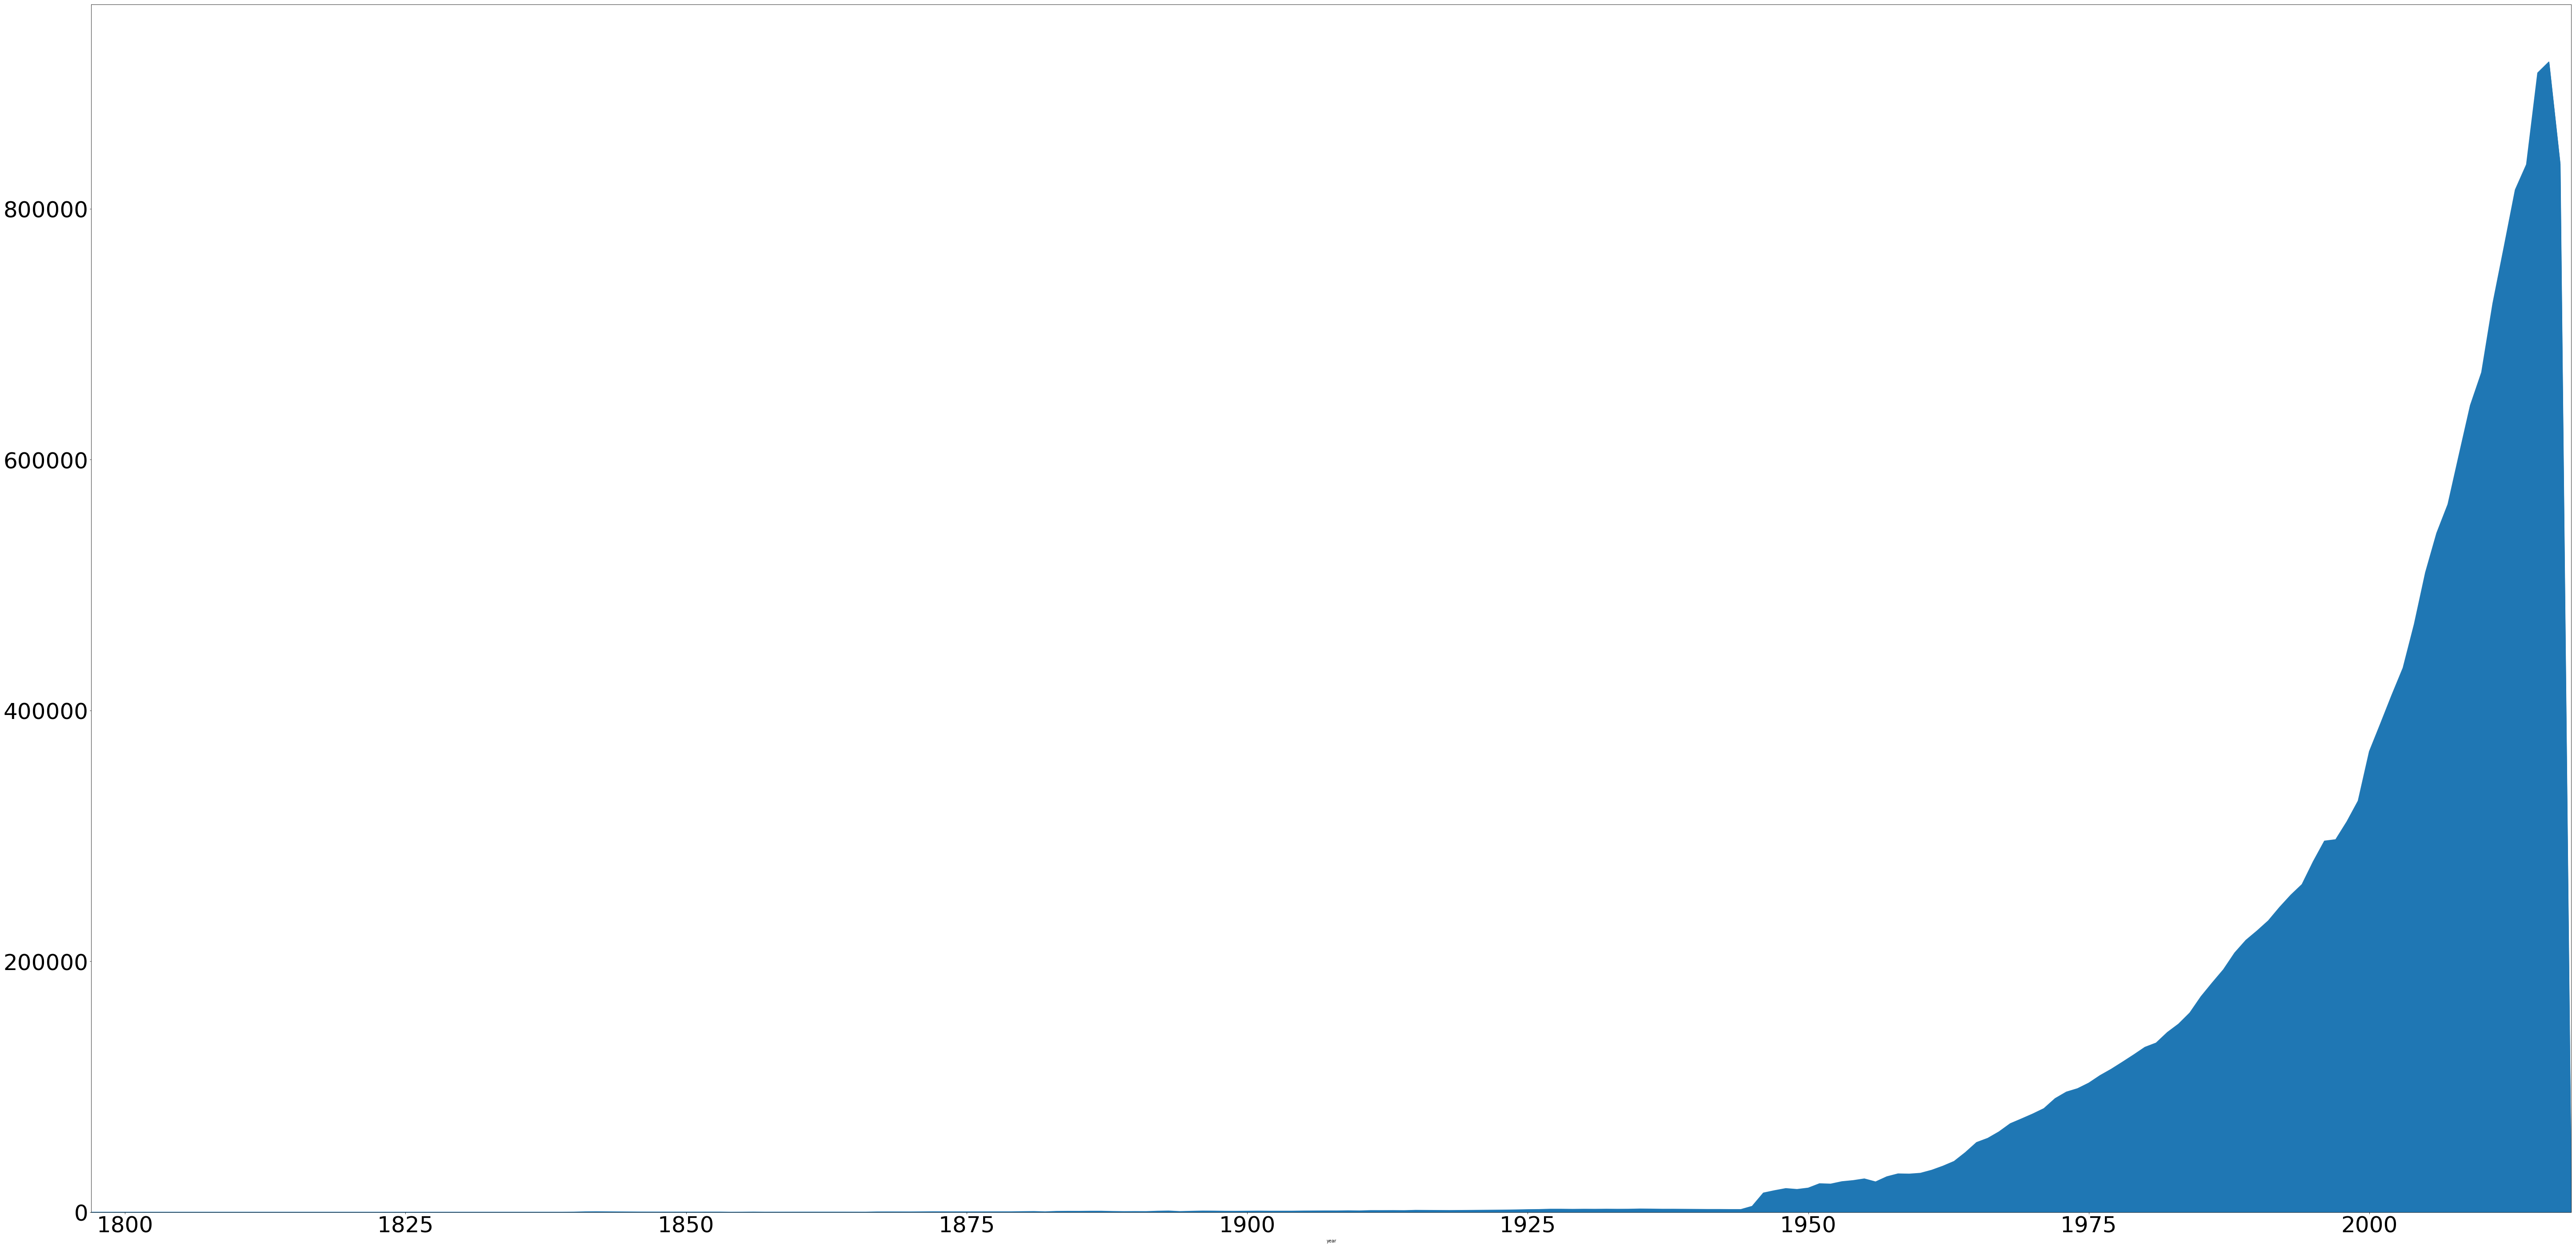

In [31]:
# plot year counts
import matplotlib.pyplot as plt  
%matplotlib inline
myfileoutfig = 'data/results/pubmed_crossref_matched_per_year.png'
ax = pmids_matched_dist.plot.area(fontsize=50, figsize=(100,50), legend=False)
fig = ax.get_figure()
fig.set_size_inches(100, 50)
fig.savefig(myfileoutfig, dpi=50)

## Compare PubMed merged with Crossref by author/year/spage and Europe PMC data

Source of Europe PMC data: https://europepmc.org/downloads 

Direct link to the 1 Gb CSV file downloaded from: ftp://ftp.ebi.ac.uk/pub/databases/pmc/DOI/ 

Informations about EUPMC matching method obtained by e-mail :

``` e-mail
-----Message d'origine-----
De : Frances Rogers via RT [mailto:helpdesk@europepmc.org] Envoyé : vendredi 19 janvier 2018 17:20 Cc : Pablo Iriarte <Pablo.Iriarte@unige.ch> Objet : [EuropePMC #236144] Europe PMC Feedback: reportproblem

Dear Pablo,

I am very sorry for the delay in my reply.

Firstly, I confused you with my first reply. We do not get DOIs from the full text XML, but from the metadata in the MEDLINE files.

1. Yes, these seem sensible and comparable to us.

We use these metadata fields to query the CrossRef API to find the DOIs:

·  ISSN
·  MEDLINE Journal abbreviation
·  First author's surname
·  Volume
·  Issue
·  First page number/letter
·  Publication year

2. We recommend using as many fields as possible to avoid false positives.

3. Yes, we are comfortable with you disclosing this information.

Best wishes,

Fran

--
Frances Rogers

Europe PMC Helpdesk
Email: helpdesk@europepmc.org
Tel: +44 (0)1223 494 118
http://europepmc.org


On Fri Jan 12 09:15:07 2018, Pablo.Iriarte@unige.ch wrote:
> Dear Fran,
> 
> Thanks for the information, it's very interesting to know that you can 
> extract DOIs form XML of full text. In our study we are going to match 
> DOIs using Crossref and PubMed metadata and then compare our results 
> with yours, used as our "gold standard". We'll use two methods :
> 
> - First author + start page
> - ISSN-L + publication year + volume + issue + pages
> 
> Now we have 3 more questions, I hope you can give me some answers
> 
> 1. Those methods make sense for you? Are them comparable with your own 
> method?
> 2. Which one do you recommend?
> 3. Can we cite the information about your mapping method in our study?
> 
> Thanks again
> Pablo
```


In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import unidecode
import pandas as pd

# import eupmc pmids with dois
myfilesin_eupmc = 'data/sources/eupmc/eupmc_pmid_doi.csv.gz'
df_eupmc = pd.read_csv(myfilesin_eupmc, sep=',', header=0, dtype={'PMID': 'int'}, compression='gzip')
df_eupmc

,PMID,PMCID,DOI
0,1,NaN,https://doi.org/10.1016/0006-2944(75)90147-7
1,10,NaN,https://doi.org/10.1002/mrd.21098
2,10,NaN,https://doi.org/10.1016/0006-2952(75)90094-5
3,1000,PMC1165682,https://doi.org/10.1042/bj1490739
4,10000,NaN,https://doi.org/10.1016/0005-2795(76)90119-7
5,1000000,NaN,https://doi.org/10.1095/biolreprod15.5.604
6,10000000,NaN,https://doi.org/10.1103/physrevb.44.3726
7,10000001,NaN,https://doi.org/10.1103/physrevb.44.3736
8,10000002,NaN,https://doi.org/10.1103/physrevb.44.3757
9,10000003,NaN,https://doi.org/10.1103/physrevb.44.3762


In [2]:
# rename columns
df_eupmc = df_eupmc.rename(columns={'PMID': 'pmid', 'DOI': 'doi'})
df_eupmc

,pmid,PMCID,doi
0,1,NaN,https://doi.org/10.1016/0006-2944(75)90147-7
1,10,NaN,https://doi.org/10.1002/mrd.21098
2,10,NaN,https://doi.org/10.1016/0006-2952(75)90094-5
3,1000,PMC1165682,https://doi.org/10.1042/bj1490739
4,10000,NaN,https://doi.org/10.1016/0005-2795(76)90119-7
5,1000000,NaN,https://doi.org/10.1095/biolreprod15.5.604
6,10000000,NaN,https://doi.org/10.1103/physrevb.44.3726
7,10000001,NaN,https://doi.org/10.1103/physrevb.44.3736
8,10000002,NaN,https://doi.org/10.1103/physrevb.44.3757
9,10000003,NaN,https://doi.org/10.1103/physrevb.44.3762


In [3]:
# number of rows in EU PMC limited to the same range that PubMed data
df_eupmc.loc[df_eupmc['pmid'] <= 29172300].shape

(17725031, 3)

In [4]:
# Import own merge
myfilesin_pubmed = 'data/results/pubmed_crossref/all/merged/pubmed_crossref_matched_all.csv.gz'
df_aumerge = pd.read_csv(myfilesin_pubmed, sep='\t', header=0, dtype={'pmid': 'int'}, compression='gzip')
df_aumerge

,pmid,year2,doi
0,1,1975,10.1016/0006-2944(75)90147-7
1,2,1975,10.1016/0006-291x(75)90482-9
2,3,1975,10.1016/0006-291x(75)90498-2
3,4,1975,10.1016/0006-291x(75)90506-9
4,5,1975,10.1016/0006-291x(75)90508-2
5,6,1975,10.1016/0006-291x(75)90518-5
6,7,1975,10.1016/0006-2952(75)90020-9
7,8,1975,10.1016/0006-2952(75)90029-5
8,9,1975,10.1016/0006-2952(75)90080-5
9,10,1975,10.1016/0006-2952(75)90094-5


In [5]:
# remove cols not used in our merge dataframe
del df_aumerge['year2']
del df_eupmc['PMCID']

In [6]:
# final size of merged data by our method
df_aumerge['pmid'].shape

(35027666,)

In [7]:
# merge two results
# df_pubmed_crossref_eupmc = df_pubmed_unique.merge(df_eupmc_unique, how='outer', left_index=True, right_index=True)
df_aumerge_eupmc = df_aumerge.merge(df_eupmc, how='outer', on='pmid')
df_aumerge_eupmc

,pmid,doi_x,doi_y
0,1,10.1016/0006-2944(75)90147-7,https://doi.org/10.1016/0006-2944(75)90147-7
1,2,10.1016/0006-291x(75)90482-9,https://doi.org/10.1016/0006-291x(75)90482-9
2,3,10.1016/0006-291x(75)90498-2,https://doi.org/10.1016/0006-291x(75)90498-2
3,4,10.1016/0006-291x(75)90506-9,https://doi.org/10.1016/0006-291x(75)90506-9
4,5,10.1016/0006-291x(75)90508-2,https://doi.org/10.1016/0006-291x(75)90508-2
5,6,10.1016/0006-291x(75)90518-5,https://doi.org/10.1016/0006-291x(75)90518-5
6,7,10.1016/0006-2952(75)90020-9,https://doi.org/10.1016/0006-2952(75)90020-9
7,8,10.1016/0006-2952(75)90029-5,https://doi.org/10.1016/0006-2952(75)90029-5
8,9,10.1016/0006-2952(75)90080-5,https://doi.org/10.1016/0006-2952(75)90080-5
9,10,10.1016/0006-2952(75)90094-5,https://doi.org/10.1002/mrd.21098


In [8]:
# exclude pmids > 29172300 (last PMID in our PubMed export)
df_aumerge_eupmc = df_aumerge_eupmc.loc[df_aumerge_eupmc['pmid'] <= 29172300]
df_aumerge_eupmc

,pmid,doi_x,doi_y
0,1,10.1016/0006-2944(75)90147-7,https://doi.org/10.1016/0006-2944(75)90147-7
1,2,10.1016/0006-291x(75)90482-9,https://doi.org/10.1016/0006-291x(75)90482-9
2,3,10.1016/0006-291x(75)90498-2,https://doi.org/10.1016/0006-291x(75)90498-2
3,4,10.1016/0006-291x(75)90506-9,https://doi.org/10.1016/0006-291x(75)90506-9
4,5,10.1016/0006-291x(75)90508-2,https://doi.org/10.1016/0006-291x(75)90508-2
5,6,10.1016/0006-291x(75)90518-5,https://doi.org/10.1016/0006-291x(75)90518-5
6,7,10.1016/0006-2952(75)90020-9,https://doi.org/10.1016/0006-2952(75)90020-9
7,8,10.1016/0006-2952(75)90029-5,https://doi.org/10.1016/0006-2952(75)90029-5
8,9,10.1016/0006-2952(75)90080-5,https://doi.org/10.1016/0006-2952(75)90080-5
9,10,10.1016/0006-2952(75)90094-5,https://doi.org/10.1002/mrd.21098


In [9]:
# export merge
df_aumerge_eupmc.to_csv('data/results/pubmed_crossref/eupmc/merge/aumerge_eupmc_all_merged.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')

In [1]:
import pandas as pd
myfilesin_pubmed_aupmc_merged = 'data/results/pubmed_crossref/eupmc/merge/aumerge_eupmc_all_merged.csv.gz'
df_aumerge_eupmc = pd.read_csv(myfilesin_pubmed_aupmc_merged, sep='\t', header=0, dtype={'pmid': 'int'}, compression='gzip')

# normalize dois: remove "https://doi.org/" and lowercase
df_aumerge_eupmc['doi_y'] = df_aumerge_eupmc['doi_y'].str.replace('https://doi.org/', '', case=False)

# remove blanks
df_aumerge_eupmc['doi_x'] = df_aumerge_eupmc['doi_x'].str.strip()
df_aumerge_eupmc['doi_y'] = df_aumerge_eupmc['doi_y'].str.strip()

# convert to lower case
df_aumerge_eupmc['doi_x'] = df_aumerge_eupmc['doi_x'].str.lower()
df_aumerge_eupmc['doi_y'] = df_aumerge_eupmc['doi_y'].str.lower()

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# test dois from EUPMC
df_aumerge_eupmc.sort_values(by='doi_y')

,pmid,doi_x,doi_y
29823427,27689381,10.1016/j.atmosenv.2016.06.033,
29823426,27689381,10.1111/ntwe.12064,
29823424,27689378,10.1016/j.ejrh.2015.12.048,
29823423,27689378,10.1016/j.agrformet.2015.07.043,
36234594,23787923,NaN,//10.1097/aog.0b013e318292aea4
34848099,29044035,10.17992/lbl.2017.10.152,//10.17992/lbl.2017.10.152
35045945,29083308,10.17992/lbl.2017.11.157,//10.17992/lbl.2017.11.157
19548647,23192809,10.1109/tuffc.2012.2478,/10.1109/tuffc.2012.2478
26599435,26415123,10.1109/tuffc.2015.007153,/10.1109/tuffc.2015.007153
36306015,24448761,NaN,/10.14573/altex.1312021


In [3]:
df_aumerge_eupmc.dtypes

pmid      int32
doi_x    object
doi_y    object
dtype: object

In [4]:
# check false DOIs from EUPMC
eupmc_wrong_dois = df_aumerge_eupmc.loc[df_aumerge_eupmc['doi_y'].notnull()]
eupmc_wrong_dois['doi_y_str'] = eupmc_wrong_dois['doi_y'].astype(str)
eupmc_wrong_dois = eupmc_wrong_dois.loc[~(eupmc_wrong_dois['doi_y_str'].str.startswith('10'))]
eupmc_wrong_dois

C:\Users\IRIARTE\AppData\Local\Continuum\Miniconda3\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,pmid,doi_x,doi_y,doi_y_str
4225075,7592970,10.1074/jbc.270.45.27151,0.1074/jbc.270.45.27339,0.1074/jbc.270.45.27339
4480643,7901128,10.1266/ggs.68.243,0.1016/0378-1119(93)90373-b,0.1016/0378-1119(93)90373-b
4480644,7901128,10.1266/jjg.68.243,0.1016/0378-1119(93)90373-b,0.1016/0378-1119(93)90373-b
4993575,8557636,10.1074/jbc.271.2.1096,0.1074/jbc.271.28.16662,0.1074/jbc.271.28.16662
5002177,8567687,10.1074/jbc.271.4.2255,0.1074/jbc.271.45.28341,0.1074/jbc.271.45.28341
5010064,8577343,10.1016/0166-6851(95)00069-d,0.1016/0166-6851(95)00069-d,0.1016/0166-6851(95)00069-d
5010066,8577343,10.1016/0166-6851(95)00124-j,0.1016/0166-6851(95)00069-d,0.1016/0166-6851(95)00069-d
5050380,8621630,10.1074/jbc.271.16.9567,0.1074/jbc.271.16.9785,0.1074/jbc.271.16.9785
5054995,8626458,10.1074/jbc.271.11.6537,0.1074/jbc.271.11.6206,0.1074/jbc.271.11.6206
5060402,8632005,10.1074/jbc.271.7.3863,0.1074/jbc.271.47.29993,0.1074/jbc.271.47.29993


In [5]:
# export EUPMC wrong DOIs to file
eupmc_wrong_dois[['pmid', 'doi_x', 'doi_y']].to_csv('data/results/pubmed_crossref/eupmc/merge/eupmc_wrong_dois.tsv', sep='\t', index=False, encoding='utf-8')


In [6]:
# DOIs in EUPMC side only
eupmc_dois_only = df_aumerge_eupmc.loc[(df_aumerge_eupmc['doi_x'].isnull()) & (df_aumerge_eupmc['doi_y'].notnull())]
eupmc_dois_only

,pmid,doi_x,doi_y
35485388,10000008,NaN,10.1103/physrevb.44.3802
35485389,1000001,NaN,10.1095/biolreprod15.5.614
35485390,10000027,NaN,10.1103/physrevb.44.3955
35485391,10000040,NaN,10.1103/physrevb.44.4024
35485392,10000041,NaN,10.1103/physrevb.44.4028
35485393,10000051,NaN,10.1103/physrevb.44.4068
35485394,10000054,NaN,10.1103/physrevb.44.4097
35485395,10000060,NaN,10.1103/physrevb.44.4146
35485396,10000076,NaN,10.1103/physrevb.44.4281
35485397,10000111,NaN,10.1103/physrevb.44.4560


In [7]:
# DOIs in PubMed merged side only
aumerge_dois_only = df_aumerge_eupmc.loc[(df_aumerge_eupmc['doi_y'].isnull()) & (df_aumerge_eupmc['doi_x'].notnull())]
aumerge_dois_only

,pmid,doi_x,doi_y
29,36,10.1017/s0007114575000530,NaN
58,63,10.1016/0005-2760(75)90151-4,NaN
59,64,10.1016/0005-2760(75)90154-x,NaN
60,65,10.1016/0005-2760(75)90159-9,NaN
74,78,10.1016/0304-4165(75)90310-4,NaN
75,79,10.1016/0005-2795(75)90348-7,NaN
76,80,10.1016/0005-2795(75)90349-9,NaN
77,81,10.1016/0005-2795(75)90351-7,NaN
78,82,10.1016/0005-2795(75)90336-0,NaN
79,83,10.1016/0005-2795(75)90034-3,NaN


In [8]:
# True positifs
tp = df_aumerge_eupmc.loc[(df_aumerge_eupmc['doi_x'] == df_aumerge_eupmc['doi_y']) & (df_aumerge_eupmc['doi_x'].notnull())]
tp['pmid'].shape

(15856035,)

In [11]:
tp

,pmid,doi_x,doi_y
0,1,10.1016/0006-2944(75)90147-7,10.1016/0006-2944(75)90147-7
1,2,10.1016/0006-291x(75)90482-9,10.1016/0006-291x(75)90482-9
2,3,10.1016/0006-291x(75)90498-2,10.1016/0006-291x(75)90498-2
3,4,10.1016/0006-291x(75)90506-9,10.1016/0006-291x(75)90506-9
4,5,10.1016/0006-291x(75)90508-2,10.1016/0006-291x(75)90508-2
5,6,10.1016/0006-291x(75)90518-5,10.1016/0006-291x(75)90518-5
6,7,10.1016/0006-2952(75)90020-9,10.1016/0006-2952(75)90020-9
7,8,10.1016/0006-2952(75)90029-5,10.1016/0006-2952(75)90029-5
8,9,10.1016/0006-2952(75)90080-5,10.1016/0006-2952(75)90080-5
10,10,10.1016/0006-2952(75)90094-5,10.1016/0006-2952(75)90094-5


In [9]:
# False positifs: DOI in both sides but different
diff_dois = df_aumerge_eupmc.loc[(df_aumerge_eupmc['doi_x'] != df_aumerge_eupmc['doi_y']) & (df_aumerge_eupmc['doi_x'].notnull()) & (df_aumerge_eupmc['doi_y'].notnull())]
diff_dois['pmid'].shape

(15901862,)

In [12]:
diff_dois

,pmid,doi_x,doi_y
9,10,10.1016/0006-2952(75)90094-5,10.1002/mrd.21098
25,32,10.1172/jci107905,10.1111/j.1365-2141.1975.tb01808.x
53,60,10.1042/bst0030215,10.1016/0005-2728(75)90124-3
55,60,10.1002/jmor.1051460204,10.1016/0005-2728(75)90124-3
71,76,10.1016/s0007-0785(75)80051-2,10.1016/0005-2744(75)90209-0
96,126,10.1007/978-1-4899-1182-7_12,10.1136/bmj.4.5994.440
143,188,10.1007/bf02413944,10.1016/s0300-9629(76)80013-8
159,202,10.1177/0040571x7507800114,10.1016/0306-4492(75)90011-8
164,207,10.1016/0076-6879(75)35139-2,10.1016/0306-4492(75)90015-5
166,207,10.1007/978-1-349-02580-0_12,10.1016/0306-4492(75)90015-5


In [10]:
# Export results
eupmc_dois_only.to_csv('data/results/pubmed_crossref/eupmc/merge/eupmc_dois_not_null_and_pubmed_merged_dois_null.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')
aumerge_dois_only.to_csv('data/results/pubmed_crossref/eupmc/merge/eupmc_dois_null_and_pubmed_merged_dois_not_null.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')
tp.to_csv('data/results/pubmed_crossref/eupmc/merge/tp_eupmc_dois_equal_pubmed_merged_dois.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')
diff_dois.to_csv('data/results/pubmed_crossref/eupmc/merge/fp1_eupmc_dois_not_null_and_pubmed_merged_dois_not_null_but_diff.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')


In [13]:
# unique PMIDs in the merge
df_aumerge_eupmc_pmids = df_aumerge_eupmc.drop_duplicates(subset='pmid')
df_aumerge_eupmc_pmids.shape

(19433010, 3)

In [23]:
# export PMIDs uniques of the diff df (False Positifs)
diff_dois_pmids = diff_dois.drop_duplicates(subset='pmid')
diff_dois_pmids.shape

(2386627, 3)

In [37]:
diff_dois_pmids['pmid'].sort_values().to_csv('data/results/pubmed_crossref/eupmc/merge/diff_dois_pmids_uniques.csv', sep='\t', index=False, encoding='utf-8')


In [34]:
# export crossref unique DOIs in the diff df
diff_dois_crossref_dois = diff_dois.drop_duplicates(subset='doi_x')
diff_dois_crossref_dois.shape

(4457657, 3)

In [38]:
diff_dois_crossref_dois['doi_x'].sort_values().to_csv('data/results/pubmed_crossref/eupmc/merge/diff_dois_crossref_dois.csv', sep='\t', index=False, encoding='utf-8')


In [39]:
# export EUPMC unique DOIs in the diff df
diff_dois_eupmc_dois = diff_dois.drop_duplicates(subset='doi_y')
diff_dois_eupmc_dois.shape

(2553096, 3)

In [40]:
diff_dois_eupmc_dois['doi_y'].sort_values().to_csv('data/results/pubmed_crossref/eupmc/merge/diff_dois_eupmc_dois.csv', sep='\t', index=False, encoding='utf-8')


In [41]:
# export PMIDs and DOIs found only by APD method
new_pmids_apd_uniques = aumerge_dois_only.drop_duplicates(subset='pmid')
new_pmids_apd_uniques.shape

(1914802, 3)

In [42]:
new_pmids_apd_uniques['pmid'].sort_values().to_csv('data/results/pubmed_crossref/eupmc/merge/new_pmids_apd_uniques.csv', sep='\t', index=False, encoding='utf-8')


In [44]:
# export crossref unique DOIs in the new df
new_pmids_apd_uniques_dois = aumerge_dois_only.drop_duplicates(subset='doi_x')
new_pmids_apd_uniques_dois.shape

(2962610, 3)

In [45]:
new_pmids_apd_uniques_dois['doi_x'].sort_values().to_csv('data/results/pubmed_crossref/eupmc/merge/new_dois_crossref_dois.csv', sep='\t', index=False, encoding='utf-8')


In [26]:
# TN = ALL NOT (APD OR EUPMC unique PMIDs)
TN = 27837540 - 19433010
TN

8404530

In [27]:
# FP = (APD AND EUPMC but DIFF) OR (APD NOT EUPMC)
FP = 15901862 + 3727491
FP

19629353

In [28]:
# TP = APD AND EUPMC and EQUAL
TP = 15856035
TP

15856035

In [29]:
# FN = EUPMC NOT APD
FN = 1647280
FN

1647280

In [30]:
# Precision (PPV) = TP / (TP + FP)
PPV = TP / (TP + FP)
PPV

0.44683279213404686

In [31]:
# Recall (sensitivity or TPR) = TP / (TP + FN)
TPR = TP / (TP + FN)
TPR

0.9058875418742107

In [32]:
# Specificity (TNR) = TN / (TN + FP)
TNR = TN / (TN + FP)
TNR

0.29979899680682837

## Results of merge

### Key numbers before comparison

 - PMIDs in PubMed export: ** 27837540 **
 - PMIDs in EUPMC export\*: ** 17725031  **
 
 
### Comparison of two methods

 - Rows after merge (APD OR EUPMC) : ** 37132668 **
 - Rows with DOI in APD and NOT in EUPMC: ** 3727491 **
 - Rows with DOI in EUPMC and NOT in APD: ** 1647280 **


 - True Positive (TP) = ** 15856035 ** 
 - True Negative (TN) = ** 8404530 ** 
 - False Positive (FP) = ** 19629353 ** 
 - False Negative (FN) = ** 1647280 ** 


 - Precision (PPV) = TP / (TP + FP) = ** 0.45 ** 
 - Recall (sensitivity or TPR) = TP / (TP + FN) = ** 0.91 ** 
 - Specificity (TNR) = TN / (TN + FP) = ** 0.30 ** 
 
 
 \* PMID <= 29172300 to have the same cut off than in the PubMed export
 

## Improving the merge

Compared to EUPMC, our method has a good sensitivity but a bad precision and specificity. Our main aim was to increase the number of PMIDs with a DOI so we decide to test all our False Positives (APD AND EUPMC but DIFF) OR (APD NOT EUPMC) comparing the titles from PubMed and Crossref using the Levenshtein distance and the title lenght as proximity score, and deciding a cut off to determine a new TP category.

The steps for this process are:

 1. Export PMID, Title, Original title and language from PubMed (done)
 2. Export DOI, Title and Original title from Crossref (done)
 3. Keep only rows for the PMIDs and DOIs concerned
 3. Normalize DOIs and Titles
 3. Add titles to FP in both sides
 4. Calculate title lenght and Levenshtein distance
 5. Calculate the similarity score: Levenshtein distance / title lenght
 6. Decide the cut off and export the new TP
 7. Add TP1 + TP2 + FN to obtain the final correspondance PMID <-> DOI
 8. Export the Final merge to a CSV file

## Normalize PubMed and Crossref titles

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import unidecode
import pandas as pd
import glob

In [2]:
# normalize PubMed titles
path =r'F:/data_sources/pubmed/extractions_xml/extraction_titles/csv'
allFiles = glob.glob(path + "/*.csv")
df_pubmed = pd.DataFrame()
i = 0
for file_ in allFiles:
    i = i + 1
    # print (file_)
    print (i)
    df = pd.read_csv(file_, sep='|', names=('pmid_orig', 'title_orig', 'original_title', 'lang'), quoting=3, error_bad_lines=False, dtype={'pmid_orig': 'object', 'title_orig': 'object'}, usecols=['pmid_orig', 'title_orig'], encoding='utf-8')
    df['pmid'] = df['pmid_orig'].astype(int)
    df['title'] = df['title_orig'].astype(str)
    mypat = (r'[^\w ]')
    df['title'] = df['title'].str.replace(mypat, ' ', case=False)
    df['title'] = df['title'].str.replace('  ', ' ', case=False)
    df['title'] = df['title'].str.lower()
    df['title'] = df['title'].str.strip()
    df['title'] = df.apply(lambda x: unidecode.unidecode(x.title), axis=1)
    df[['pmid', 'title']].to_csv('F:/data_sources/pubmed/extractions_xml/extraction_titles/csv_normalized/' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [3]:
# normalize Crossref titles
filename1 ='F:\data_sources\crossref\crossref_extractions\doi_titles\data_all_20171219\crossref-works-metadata.tsv'
filename2 ='F:\data_sources\crossref\crossref_extractions\doi_titles\data_after_2015_20180201\crossref-works-metadata.tsv'
chunksize = 10 ** 5
i = 0
for chunk in pd.read_csv(filename1, chunksize=chunksize, sep='|', header=0, error_bad_lines=False, dtype={'doi': 'object', 'title': 'object'}, usecols=['doi', 'title'], encoding='utf-8'):
    i = i + 1
    print ('1 - ' + str(i))
    chunk['title'] = chunk['title'].astype(str)
    mypat = (r'[^\w ]')
    chunk['title'] = chunk['title'].str.replace(mypat, ' ', case=False)
    chunk['title'] = chunk['title'].str.replace('  ', ' ', case=False)
    chunk['title'] = chunk['title'].str.lower()
    chunk['title'] = chunk['title'].str.strip()
    chunk['title'] = chunk.apply(lambda x: unidecode.unidecode(x.title), axis=1)
    chunk['doi'] = chunk['doi'].str.lower()
    chunk['doi'] = chunk['doi'].str.strip()
    chunk[['doi', 'title']].to_csv('F:/data_sources/crossref/crossref_extractions/doi_titles/csv_normalized/file1_' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')
i = 0
for chunk in pd.read_csv(filename2, chunksize=chunksize, sep='|', header=0, error_bad_lines=False, dtype={'doi': 'object', 'title': 'object'}, usecols=['doi', 'title'], encoding='utf-8'):
    i = i + 1
    print ('2 - ' + str(i))
    chunk['title'] = chunk['title'].astype(str)
    mypat = (r'[^\w ]')
    chunk['title'] = chunk['title'].str.replace(mypat, ' ', case=False)
    chunk['title'] = chunk['title'].str.replace('  ', ' ', case=False)
    chunk['title'] = chunk['title'].str.lower()
    chunk['title'] = chunk['title'].str.strip()
    chunk['title'] = chunk.apply(lambda x: unidecode.unidecode(x.title), axis=1)
    chunk['doi'] = chunk['doi'].str.lower()
    chunk['doi'] = chunk['doi'].str.strip()
    chunk[['doi', 'title']].to_csv('F:/data_sources/crossref/crossref_extractions/doi_titles/csv_normalized/file2_' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')


1 - 1
1 - 2
1 - 3
1 - 4
1 - 5
1 - 6
1 - 7
1 - 8
1 - 9
1 - 10
1 - 11
1 - 12
1 - 13
1 - 14
1 - 15
1 - 16
1 - 17
1 - 18
1 - 19
1 - 20
1 - 21
1 - 22
1 - 23
1 - 24
1 - 25
1 - 26
1 - 27
1 - 28
1 - 29
1 - 30
1 - 31
1 - 32
1 - 33
1 - 34
1 - 35
1 - 36
1 - 37
1 - 38
1 - 39
1 - 40
1 - 41
1 - 42
1 - 43
1 - 44
1 - 45
1 - 46
1 - 47
1 - 48
1 - 49
1 - 50
1 - 51
1 - 52
1 - 53
1 - 54
1 - 55
1 - 56
1 - 57
1 - 58
1 - 59
1 - 60
1 - 61
1 - 62
1 - 63
1 - 64
1 - 65
1 - 66
1 - 67
1 - 68
1 - 69
1 - 70
1 - 71
1 - 72
1 - 73
1 - 74
1 - 75
1 - 76
1 - 77
1 - 78
1 - 79
1 - 80
1 - 81
1 - 82
1 - 83
1 - 84
1 - 85
1 - 86
1 - 87
1 - 88
1 - 89
1 - 90
1 - 91
1 - 92
1 - 93
1 - 94
1 - 95
1 - 96
1 - 97
1 - 98
1 - 99
1 - 100
1 - 101
1 - 102
1 - 103
1 - 104
1 - 105
1 - 106
1 - 107
1 - 108
1 - 109
1 - 110
1 - 111
1 - 112
1 - 113
1 - 114
1 - 115
1 - 116
1 - 117
1 - 118
1 - 119
1 - 120
1 - 121
1 - 122
1 - 123
1 - 124
1 - 125
1 - 126
1 - 127
1 - 128
1 - 129
1 - 130
1 - 131
1 - 132
1 - 133
1 - 134
1 - 135
1 - 136
1 - 137
1 - 138
1 - 

## Comparing Titles from FP 1 (new DOIs in APD part only)


In [2]:
# import FP1 (APD NOT EUPMC) 
df_pubmed_apd = pd.read_csv('data/results/pubmed_crossref/eupmc/merge/new_pmids_apd_uniques.csv', header=-1, sep='\t', dtype={'pmid': 'int'}, encoding='utf-8')
df_pubmed_apd = df_pubmed_apd.rename(columns={0: 'pmid'})
df_pubmed_apd

,pmid
0,36
1,63
2,64
3,65
4,78
5,79
6,80
7,81
8,82
9,83


In [3]:
df_pubmed_apd['fp'] = 1
df_pubmed_apd

,pmid,fp
0,36,1
1,63,1
2,64,1
3,65,1
4,78,1
5,79,1
6,80,1
7,81,1
8,82,1
9,83,1


In [4]:
path =r'F:/data_sources/pubmed/extractions_xml/extraction_titles/csv_normalized'
allFiles = glob.glob(path + "/*.csv")
df_pubmed = pd.DataFrame()
i = 0
for file_ in allFiles:
    i = i + 1
    # print (file_)
    print (i)
    df = pd.read_csv(file_, sep='\t', header=0, encoding='utf-8')
    # df['pmid'] = df['pmid1'].astype(int)
    df_pubmed = df.merge(df_pubmed_apd, on='pmid', how='left')
    df_pubmed.loc[df_pubmed['fp'] == 1][['pmid', 'title']].to_csv('data/results/pubmed_crossref/eupmc/merge/pubmed_titles_apd_new/' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [5]:
# Import PubMed titles (1914802 unique PMIDs at the beginning)
myfilesin_pubmed = 'data/results/pubmed_crossref/eupmc/merge/pubmed_titles_apd_new/*.csv'
df_pubmed = dd.read_csv(myfilesin_pubmed, sep='\t', header=0, names=('pmid', 'title'), encoding='utf-8')
df_pubmed

,pmid,title
npartitions=928,,
,int64,object
,...,...
...,...,...
,...,...
,...,...


In [6]:
with ProgressBar():
    df_pubmed_pandas = df_pubmed.compute()
df_pubmed_pandas

[########################################] | 100% Completed | 14.6s


,pmid,title
0,36,the effects of processing of barley based supp...
1,63,enzymic reactions of fatty acid hydroperoxides...
2,64,partial purification and properties of microso...
3,65,bile acids xlvii 12alpha hydroxylation of prec...
4,78,studies on rat renal cortical cell kallikrein ...
5,79,studies on electron transfer between mercury e...
6,80,the binding of organic phosphates to human met...
7,81,n terminal spin label studies of hemoglobin li...
8,82,the behavior of holo and apo forms of bovine s...
9,83,mechanical precipitation of hemoglobin koln


In [24]:
# dedup dataframe (created from two crossref files not distinct)
df_pubmed_pandas_dedup = df_pubmed_pandas.drop_duplicates(subset='pmid')
df_pubmed_pandas_dedup

,pmid,title
0,36,the effects of processing of barley based supp...
1,63,enzymic reactions of fatty acid hydroperoxides...
2,64,partial purification and properties of microso...
3,65,bile acids xlvii 12alpha hydroxylation of prec...
4,78,studies on rat renal cortical cell kallikrein ...
5,79,studies on electron transfer between mercury e...
6,80,the binding of organic phosphates to human met...
7,81,n terminal spin label studies of hemoglobin li...
8,82,the behavior of holo and apo forms of bovine s...
9,83,mechanical precipitation of hemoglobin koln


In [25]:
# Export to CSV
df_pubmed_pandas_dedup.to_csv('data/results/pubmed_crossref/eupmc/merge/pubmed_titles_new_dois_ready_to_merge.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

In [26]:
# import Crossref titles for FP1 (APD NOT EUPMC) 
df_dois_apd = pd.read_csv('data/results/pubmed_crossref/eupmc/merge/new_dois_crossref_dois.csv', header=-1, sep='\t', encoding='utf-8')
df_dois_apd = df_dois_apd.rename(columns={0: 'doi'})
df_dois_apd

,doi
0,10.1001/archderm.100.2.148
1,10.1001/archderm.100.2.222
2,10.1001/archderm.100.2.230
3,10.1001/archderm.100.3.312
4,10.1001/archderm.102.2.199
5,10.1001/archderm.102.4.368
6,10.1001/archderm.103.1.11
7,10.1001/archderm.103.2.201
8,10.1001/archderm.103.3.287
9,10.1001/archderm.103.5.501


In [27]:
df_dois_apd['fp'] = 1
df_dois_apd

,doi,fp
0,10.1001/archderm.100.2.148,1
1,10.1001/archderm.100.2.222,1
2,10.1001/archderm.100.2.230,1
3,10.1001/archderm.100.3.312,1
4,10.1001/archderm.102.2.199,1
5,10.1001/archderm.102.4.368,1
6,10.1001/archderm.103.1.11,1
7,10.1001/archderm.103.2.201,1
8,10.1001/archderm.103.3.287,1
9,10.1001/archderm.103.5.501,1


In [28]:
path =r'F:/data_sources/crossref/crossref_extractions/doi_titles/csv_normalized'
allFiles = glob.glob(path + "/*.csv")
df_crossref = pd.DataFrame()
i = 0
for file_ in allFiles:
    i = i + 1
    print (i)
    df = pd.read_csv(file_, sep='\t', header=0, encoding='utf-8')
    df_crossref = df.merge(df_dois_apd, on='doi', how='left')
    df_crossref.loc[df_crossref['fp'] == 1][['doi', 'title']].to_csv('data/results/pubmed_crossref/eupmc/merge/crossref_titles_apd_new/' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [29]:
# Import Crossref titles (from 2962610 unique DOIs at the beginning)
myfilesin_crossref = 'data/results/pubmed_crossref/eupmc/merge/crossref_titles_apd_new/*.csv'
df_crossref = dd.read_csv(myfilesin_crossref, sep='\t', header=0, encoding='utf-8')
df_crossref

,doi,title
npartitions=1061,,
,object,object
,...,...
...,...,...
,...,...
,...,...


In [30]:
with ProgressBar():
    df_crossref_pandas = df_crossref.compute()
df_crossref_pandas

[########################################] | 100% Completed | 20.2s


,doi,title
0,10.1002/(sici)1096-8628(19960111)61:2<122::aid...,renal insufficiency is a component of coach sy...
1,10.1002/(sici)1096-8628(19960301)62:1<77::aid-...,distal 8p deletion 8 p23 1 an easily missed c...
2,10.1002/(sici)1096-8628(19960726)67:4<418::aid...,no association of dopamine d2 receptor molecul...
3,10.1002/(sici)1096-8628(19961122)67:6<560::aid...,chromosome 18 translocation 18 21 p11 1 p11 1...
4,10.1002/(sici)1096-8628(19961218)66:3<273::aid...,distichiasis lymphedema syndrome tetralogy of ...
5,10.1002/(sici)1096-8628(19961218)66:3<370::aid...,color atlas of genetics
6,10.1002/(sici)1096-8628(19970120)68:2<121::aid...,marshall stickler phenotype associated with vo...
7,10.1002/(sici)1096-8628(19970221)74:1<12::aid-...,comparison of the family history with the fami...
8,10.1002/(sici)1096-8628(19970221)74:1<37::aid-...,no evidence for an allelic association between...
9,10.1002/(sici)1096-8628(19970221)74:1<40::aid-...,further evidence of no association between ser...


In [31]:
# dedup dataframe (created from two crossref files not distinct)
df_crossref_pandas_dedup = df_crossref_pandas.drop_duplicates(subset='doi')
df_crossref_pandas_dedup

,doi,title
0,10.1002/(sici)1096-8628(19960111)61:2<122::aid...,renal insufficiency is a component of coach sy...
1,10.1002/(sici)1096-8628(19960301)62:1<77::aid-...,distal 8p deletion 8 p23 1 an easily missed c...
2,10.1002/(sici)1096-8628(19960726)67:4<418::aid...,no association of dopamine d2 receptor molecul...
3,10.1002/(sici)1096-8628(19961122)67:6<560::aid...,chromosome 18 translocation 18 21 p11 1 p11 1...
4,10.1002/(sici)1096-8628(19961218)66:3<273::aid...,distichiasis lymphedema syndrome tetralogy of ...
5,10.1002/(sici)1096-8628(19961218)66:3<370::aid...,color atlas of genetics
6,10.1002/(sici)1096-8628(19970120)68:2<121::aid...,marshall stickler phenotype associated with vo...
7,10.1002/(sici)1096-8628(19970221)74:1<12::aid-...,comparison of the family history with the fami...
8,10.1002/(sici)1096-8628(19970221)74:1<37::aid-...,no evidence for an allelic association between...
9,10.1002/(sici)1096-8628(19970221)74:1<40::aid-...,further evidence of no association between ser...


In [32]:
# Export to CSV
df_crossref_pandas_dedup.to_csv('data/results/pubmed_crossref/eupmc/merge/crossref_titles_new_dois_ready_to_merge.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

In [33]:
# open rows with DOIs in APD side only
myfilein = 'data/results/pubmed_crossref/eupmc/merge/eupmc_dois_null_and_pubmed_merged_dois_not_null.csv.gz'
df_apd_dois = pd.read_csv(myfilein, sep='\t', header=0, encoding='utf-8', usecols=('pmid', 'doi_x'))
df_apd_dois = df_apd_dois.rename(columns={'doi_x': 'doi'})
df_apd_dois

,pmid,doi
0,36,10.1017/s0007114575000530
1,63,10.1016/0005-2760(75)90151-4
2,64,10.1016/0005-2760(75)90154-x
3,65,10.1016/0005-2760(75)90159-9
4,78,10.1016/0304-4165(75)90310-4
5,79,10.1016/0005-2795(75)90348-7
6,80,10.1016/0005-2795(75)90349-9
7,81,10.1016/0005-2795(75)90351-7
8,82,10.1016/0005-2795(75)90336-0
9,83,10.1016/0005-2795(75)90034-3


In [34]:
# merge PubMed titles
df_apd_dois = df_apd_dois.merge(df_pubmed_pandas_dedup, on='pmid', how='left')
df_apd_dois = df_apd_dois.rename(columns={'title': 'title_pubmed'})
df_apd_dois

,pmid,doi,title_pubmed
0,36,10.1017/s0007114575000530,the effects of processing of barley based supp...
1,63,10.1016/0005-2760(75)90151-4,enzymic reactions of fatty acid hydroperoxides...
2,64,10.1016/0005-2760(75)90154-x,partial purification and properties of microso...
3,65,10.1016/0005-2760(75)90159-9,bile acids xlvii 12alpha hydroxylation of prec...
4,78,10.1016/0304-4165(75)90310-4,studies on rat renal cortical cell kallikrein ...
5,79,10.1016/0005-2795(75)90348-7,studies on electron transfer between mercury e...
6,80,10.1016/0005-2795(75)90349-9,the binding of organic phosphates to human met...
7,81,10.1016/0005-2795(75)90351-7,n terminal spin label studies of hemoglobin li...
8,82,10.1016/0005-2795(75)90336-0,the behavior of holo and apo forms of bovine s...
9,83,10.1016/0005-2795(75)90034-3,mechanical precipitation of hemoglobin koln


In [35]:
# merge Crossref titles
df_apd_dois = df_apd_dois.merge(df_crossref_pandas_dedup, on='doi', how='left')
df_apd_dois = df_apd_dois.rename(columns={'title': 'title_crossref'})
df_apd_dois

,pmid,doi,title_pubmed,title_crossref
0,36,10.1017/s0007114575000530,the effects of processing of barley based supp...,the effects of processing of barley based supp...
1,63,10.1016/0005-2760(75)90151-4,enzymic reactions of fatty acid hydroperoxides...,enzymic reactions of fatty acid hydroperoxides...
2,64,10.1016/0005-2760(75)90154-x,partial purification and properties of microso...,partial purification and properties of microso...
3,65,10.1016/0005-2760(75)90159-9,bile acids xlvii 12alpha hydroxylation of prec...,bile acids xlvii 12a hydroxylation of precurso...
4,78,10.1016/0304-4165(75)90310-4,studies on rat renal cortical cell kallikrein ...,studies on rat renal cortical cell kallikrein ...
5,79,10.1016/0005-2795(75)90348-7,studies on electron transfer between mercury e...,studies on electron transfer between mercury e...
6,80,10.1016/0005-2795(75)90349-9,the binding of organic phosphates to human met...,the binding of organic phosphates to human met...
7,81,10.1016/0005-2795(75)90351-7,n terminal spin label studies of hemoglobin li...,n terminal spin label studies of hemoglobin li...
8,82,10.1016/0005-2795(75)90336-0,the behavior of holo and apo forms of bovine s...,the behavior of holo and apo forms of bovine s...
9,83,10.1016/0005-2795(75)90034-3,mechanical precipitation of hemoglobin koln,mechanical precipitation of hemoglobin koln


In [36]:
# export to file just in case
myfileout = 'data/results/pubmed_crossref/eupmc/merge/eupmc_dois_null_and_pubmed_merged_dois_not_null_with_titles.csv.gz'
df_apd_dois.to_csv(myfileout, sep='\t', encoding='utf-8', compression='gzip', index=False)

In [37]:
# convert to string to avoid errors
df_apd_dois['title_pubmed'] = df_apd_dois['title_pubmed'].astype(str)
df_apd_dois['title_crossref'] = df_apd_dois['title_crossref'].astype(str)

In [38]:
# calculate Levenshtein distance
from nltk.metrics import edit_distance
df_apd_dois['titles_distance'] = df_apd_dois.apply(lambda x: edit_distance(x['title_pubmed'], x['title_crossref']), axis=1)
df_apd_dois

,pmid,doi,title_pubmed,title_crossref,titles_distance
0,36,10.1017/s0007114575000530,the effects of processing of barley based supp...,the effects of processing of barley based supp...,3
1,63,10.1016/0005-2760(75)90151-4,enzymic reactions of fatty acid hydroperoxides...,enzymic reactions of fatty acid hydroperoxides...,0
2,64,10.1016/0005-2760(75)90154-x,partial purification and properties of microso...,partial purification and properties of microso...,0
3,65,10.1016/0005-2760(75)90159-9,bile acids xlvii 12alpha hydroxylation of prec...,bile acids xlvii 12a hydroxylation of precurso...,4
4,78,10.1016/0304-4165(75)90310-4,studies on rat renal cortical cell kallikrein ...,studies on rat renal cortical cell kallikrein ...,0
5,79,10.1016/0005-2795(75)90348-7,studies on electron transfer between mercury e...,studies on electron transfer between mercury e...,0
6,80,10.1016/0005-2795(75)90349-9,the binding of organic phosphates to human met...,the binding of organic phosphates to human met...,60
7,81,10.1016/0005-2795(75)90351-7,n terminal spin label studies of hemoglobin li...,n terminal spin label studies of hemoglobin li...,0
8,82,10.1016/0005-2795(75)90336-0,the behavior of holo and apo forms of bovine s...,the behavior of holo and apo forms of bovine s...,0
9,83,10.1016/0005-2795(75)90034-3,mechanical precipitation of hemoglobin koln,mechanical precipitation of hemoglobin koln,0


In [39]:
# Add title string lenghts and words number
df_apd_dois['title_pubmed_str_lenght'] = df_apd_dois['title_pubmed'].str.len()
df_apd_dois['title_crossref_str_lenght'] = df_apd_dois['title_crossref'].str.len()
df_apd_dois

,pmid,doi,title_pubmed,title_crossref,titles_distance,title_pubmed_str_lenght,title_crossref_str_lenght
0,36,10.1017/s0007114575000530,the effects of processing of barley based supp...,the effects of processing of barley based supp...,3,127,128
1,63,10.1016/0005-2760(75)90151-4,enzymic reactions of fatty acid hydroperoxides...,enzymic reactions of fatty acid hydroperoxides...,0,215,215
2,64,10.1016/0005-2760(75)90154-x,partial purification and properties of microso...,partial purification and properties of microso...,0,95,95
3,65,10.1016/0005-2760(75)90159-9,bile acids xlvii 12alpha hydroxylation of prec...,bile acids xlvii 12a hydroxylation of precurso...,4,98,94
4,78,10.1016/0304-4165(75)90310-4,studies on rat renal cortical cell kallikrein ...,studies on rat renal cortical cell kallikrein ...,0,74,74
5,79,10.1016/0005-2795(75)90348-7,studies on electron transfer between mercury e...,studies on electron transfer between mercury e...,0,70,70
6,80,10.1016/0005-2795(75)90349-9,the binding of organic phosphates to human met...,the binding of organic phosphates to human met...,60,119,59
7,81,10.1016/0005-2795(75)90351-7,n terminal spin label studies of hemoglobin li...,n terminal spin label studies of hemoglobin li...,0,68,68
8,82,10.1016/0005-2795(75)90336-0,the behavior of holo and apo forms of bovine s...,the behavior of holo and apo forms of bovine s...,0,75,75
9,83,10.1016/0005-2795(75)90034-3,mechanical precipitation of hemoglobin koln,mechanical precipitation of hemoglobin koln,0,43,43


In [40]:
# Calculate score
df_apd_dois['titles_distance_score'] = 0
df_apd_dois['titles_distance_score'] = 1 - (df_apd_dois['titles_distance'] / (df_apd_dois[['title_pubmed_str_lenght', 'title_crossref_str_lenght']].max(axis=1)))
df_apd_dois.sort_values(by='titles_distance_score', ascending=False)

,pmid,doi,title_pubmed,title_crossref,titles_distance,title_pubmed_str_lenght,title_crossref_str_lenght,titles_distance_score
1863745,14254007,10.1016/0926-6550(64)90065-9,mechanism of action of glucose and pyrimidine ...,mechanism of action of glucose and pyrimidine ...,0,109,109,1.0
1562389,11649792,10.2307/796440,redefining mother a legal matrix for new repro...,redefining mother a legal matrix for new repro...,0,66,66,1.0
699109,4970080,10.3181/00379727-128-33115,distribution of lysozyme in the rat kidney and...,distribution of lysozyme in the rat kidney and...,0,101,101,1.0
699110,4970081,10.3181/00379727-128-33122,erythropoietin release in baboons after renal ...,erythropoietin release in baboons after renal ...,0,65,65,1.0
699111,4970083,10.1159/000208953,nitrocatecholsulfatase in human blood platelets,nitrocatecholsulfatase in human blood platelets,0,47,47,1.0
1562412,11649860,10.5840/ijap1987332,interprofessional ethics in health care,interprofessional ethics in health care,0,39,39,1.0
1562410,11649857,10.2307/3312073,creating a private cause of action against abu...,creating a private cause of action against abu...,0,66,66,1.0
1562405,11649848,10.2753/rup1061-1940200471,on medical secrecy,on medical secrecy,0,18,18,1.0
699115,4970087,10.1159/000208958,the inheritance of leukaemia and cancer,the inheritance of leukaemia and cancer,0,39,39,1.0
699116,4970088,10.1159/000208959,on the origin of monocytes,on the origin of monocytes,0,26,26,1.0


In [41]:
# Export to CSV
df_apd_dois.sort_values(by='titles_distance_score', ascending=False).to_csv('data/results/pubmed_crossref/eupmc/merge/apd_new_dois_with_titles_and_score.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

In [43]:
# Cut off
mycutoff = 0.8
df_apd_dois_good = df_apd_dois.loc[df_apd_dois['titles_distance_score'] >= mycutoff]
df_apd_dois_bad = df_apd_dois.loc[df_apd_dois['titles_distance_score'] < mycutoff]
df_apd_dois_bad.sort_values(by='titles_distance_score', ascending=False)

,pmid,doi,title_pubmed,title_crossref,titles_distance,title_pubmed_str_lenght,title_crossref_str_lenght,titles_distance_score
832713,6154812,10.1253/jcj.44.264,clinical and histopathological profile of sarc...,clinical and histopathological profile of sarc...,43,171,214,0.799065
2581793,20895628,10.1177/095952873501900108,a case of sudden illness in advanced pregnancy...,a case of sudden illness in advanced pregnancy...,43,171,214,0.799065
1464711,10702677,10.1159/000015431,protein tyrosine phosphatase receptor type c p...,protein tyrosine phosphatase receptor type c p...,41,171,204,0.799020
3343421,26473236,10.11646/zootaxa.3686.4.7,first cave records for palearctic burrower bug...,p class headingrunin strong first cave record...,39,155,194,0.798969
2111330,16566622,10.4088/jcp.v67n0213,imipramine is effective in preventing relapse ...,imipramine is effective in preventing relapse ...,38,189,151,0.798942
258072,1939462,10.1016/0378-4347(91)80268-h,direct in vitro and in vivo monitoring of dest...,direct in vitro and in vivo monitoring of dest...,38,189,151,0.798942
1044298,7624926,10.1097/00007691-199506000-00013,plasma concentrations of morphine morphine 3 g...,plasma concentrations of morphine morphine 3 g...,37,184,147,0.798913
1350638,9804464,10.1097/00002480-199809000-00019,bioincompatibility of dialyzer membranes may h...,bioincompatibility of dialyzer membranes may h...,37,184,147,0.798913
179976,1448311,10.1097/00006454-199209000-00009,comparative efficacy of oral rifampin and topi...,comparative efficacy of oral rifampin and topi...,37,184,147,0.798913
742640,5350505,10.7164/antibiotics.22.484,transmission of the r factor by conjugation fr...,the journal of antibiotics oct 1969 transmissi...,36,143,179,0.798883


In [45]:
df_apd_dois_good.sort_values(by='titles_distance_score', ascending=False)

,pmid,doi,title_pubmed,title_crossref,titles_distance,title_pubmed_str_lenght,title_crossref_str_lenght,titles_distance_score
1036904,7577347,10.1007/978-1-4615-2013-9_5,cytomegalovirus infection in marrow transplant...,cytomegalovirus infection in marrow transplant...,0,51,51,1.0
1466393,10721078,10.1007/978-1-4615-4709-9_47,hormonal influences on tryptophan binding to r...,hormonal influences on tryptophan binding to r...,0,63,63,1.0
1466395,10721080,10.1007/978-1-4615-4709-9_49,indole 3 pyruvic and propionic acids kynurenic...,indole 3 pyruvic and propionic acids kynurenic...,0,119,119,1.0
1466397,10721082,10.1007/978-1-4615-4709-9_51,tryptanthrins and other tryptophan derived ago...,tryptanthrins and other tryptophan derived ago...,0,74,74,1.0
1466398,10721083,10.1007/978-1-4615-4709-9_52,induction of cytochrome p4501a1 by ozone oxidi...,induction of cytochrome p4501a1 by ozone oxidi...,0,80,80,1.0
1466399,10721084,10.1007/978-1-4615-4709-9_53,cinnabarinic acid was formed in damaged mitoch...,cinnabarinic acid was formed in damaged mitoch...,0,96,96,1.0
1466400,10721085,10.1007/978-1-4615-4709-9_54,effects of fusarium mycotoxins on levels of se...,effects of fusarium mycotoxins on levels of se...,0,111,111,1.0
1466401,10721086,10.1007/978-1-4615-4709-9_55,dioxin induced perturbations in tryptophan hom...,dioxin induced perturbations in tryptophan hom...,0,76,76,1.0
1466403,10721088,10.1007/978-1-4615-4709-9_57,structural characterization of case associated...,structural characterization of case associated...,0,133,133,1.0
1466404,10721089,10.1007/978-1-4615-4709-9_58,eosinophilia myalgia syndrome case associated ...,eosinophilia myalgia syndrome case associated ...,0,104,104,1.0


In [44]:
# Export to CSV
df_apd_dois_good.sort_values(by='titles_distance_score', ascending=False).to_csv('data/results/pubmed_crossref/eupmc/merge/apd_new_dois_with_titles_and_score_good.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')
df_apd_dois_bad.sort_values(by='titles_distance_score', ascending=False).to_csv('data/results/pubmed_crossref/eupmc/merge/apd_new_dois_with_titles_and_score_bad.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

In [46]:
# export first 10000 bad matches
df_apd_dois_bad.sort_values(by='titles_distance_score', ascending=False).head(10000).to_csv('data/results/pubmed_crossref/eupmc/merge/apd_new_dois_with_titles_and_score_bad_head_1000.csv', sep='\t', index=False, encoding='utf-8')

In [47]:
# test with 0.7 as cutoff
df_apd_dois.loc[df_apd_dois['titles_distance_score'] >= 0.7]

,pmid,doi,title_pubmed,title_crossref,titles_distance,title_pubmed_str_lenght,title_crossref_str_lenght,titles_distance_score
0,36,10.1017/s0007114575000530,the effects of processing of barley based supp...,the effects of processing of barley based supp...,3,127,128,0.976562
1,63,10.1016/0005-2760(75)90151-4,enzymic reactions of fatty acid hydroperoxides...,enzymic reactions of fatty acid hydroperoxides...,0,215,215,1.000000
2,64,10.1016/0005-2760(75)90154-x,partial purification and properties of microso...,partial purification and properties of microso...,0,95,95,1.000000
3,65,10.1016/0005-2760(75)90159-9,bile acids xlvii 12alpha hydroxylation of prec...,bile acids xlvii 12a hydroxylation of precurso...,4,98,94,0.959184
4,78,10.1016/0304-4165(75)90310-4,studies on rat renal cortical cell kallikrein ...,studies on rat renal cortical cell kallikrein ...,0,74,74,1.000000
5,79,10.1016/0005-2795(75)90348-7,studies on electron transfer between mercury e...,studies on electron transfer between mercury e...,0,70,70,1.000000
7,81,10.1016/0005-2795(75)90351-7,n terminal spin label studies of hemoglobin li...,n terminal spin label studies of hemoglobin li...,0,68,68,1.000000
8,82,10.1016/0005-2795(75)90336-0,the behavior of holo and apo forms of bovine s...,the behavior of holo and apo forms of bovine s...,0,75,75,1.000000
9,83,10.1016/0005-2795(75)90034-3,mechanical precipitation of hemoglobin koln,mechanical precipitation of hemoglobin koln,0,43,43,1.000000
10,84,10.1016/0005-2795(75)90035-5,physical properties and subunits of haemopis g...,physical properties and subunits of haemopis g...,0,67,67,1.000000


In [48]:
# Export only PMID and DOI for the good part
df_apd_dois_good[['pmid', 'doi']].sort_values(by='pmid').to_csv('data/results/pubmed_crossref/eupmc/merge/apd_new_dois_with_titles_and_score_good_pmids_dois.csv', sep='\t', index=False, encoding='utf-8')

In [51]:
# see if some PMIDs are duplicated or not
df_apd_dois_good_duplicated_pmids = df_apd_dois_good.loc[df_apd_dois_good.duplicated(subset='pmid', keep=False)]
df_apd_dois_good_duplicated_pmids

,pmid,doi,title_pubmed,title_crossref,titles_distance,title_pubmed_str_lenght,title_crossref_str_lenght,titles_distance_score
274,1841,10.1007/978-3-662-35091-1_1,the role of cyclic nucleotides in central syna...,the role of cyclic nucleotides in central syna...,0,59,59,1.000000
279,1841,10.1007/3-540-07483-x_19,the role of cyclic nucleotides in central syna...,the role of cyclic nucleotides in central syna...,0,59,59,1.000000
280,1844,10.1080/00365517509095792,normal arterial blood gases during experimenta...,normal arterial blood gases during experimenta...,0,79,79,1.000000
281,1844,10.3109/00365517509095792,normal arterial blood gases during experimenta...,normal arterial blood gases during experimenta...,0,79,79,1.000000
758,6497,10.1037//0022-0663.68.3.297,effect of counterconditioning on test anxiety ...,effect of counterconditioning on test anxiety ...,0,84,84,1.000000
759,6497,10.1037/0022-0663.68.3.297,effect of counterconditioning on test anxiety ...,effect of counterconditioning on test anxiety ...,0,84,84,1.000000
819,6986,10.1037/0033-2909.83.3.431,maintenance antipsychotic drugs do prevent rel...,maintenance antipsychotic drugs do prevent rel...,0,82,82,1.000000
821,6986,10.1037//0033-2909.83.3.431,maintenance antipsychotic drugs do prevent rel...,maintenance antipsychotic drugs do prevent rel...,0,82,82,1.000000
822,6987,10.1037//0033-2909.83.3.448,withdrawal causes relapse our response,withdrawal causes relapse our response,0,38,38,1.000000
823,6987,10.1037/0033-2909.83.3.448,withdrawal causes relapse our response,withdrawal causes relapse our response,0,38,38,1.000000


In [53]:
df_apd_dois_good_duplicated_pmids.shape

(53913, 8)

In [54]:
# Export
df_apd_dois_good_duplicated_pmids.sort_values(by='pmid').to_csv('data/results/pubmed_crossref/eupmc/merge/apd_new_dois_with_titles_and_score_good_pmid_duplicated.csv', sep='\t', index=False, encoding='utf-8')

## Comparing Titles from FP 2 (DOIs in both sides but different)


In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import unidecode
import pandas as pd
import glob

In [2]:
# import FP 2 (DOIs in both sides but different) 
df_pubmed_apd_eupmc_dois_diff = pd.read_csv('data/results/pubmed_crossref/eupmc/merge/diff_dois_pmids_uniques.csv', header=-1, sep='\t', dtype={'pmid': 'int'}, encoding='utf-8')
df_pubmed_apd_eupmc_dois_diff = df_pubmed_apd_eupmc_dois_diff.rename(columns={0: 'pmid'})
df_pubmed_apd_eupmc_dois_diff

,pmid
0,10
1,32
2,60
3,76
4,126
5,188
6,202
7,207
8,235
9,238


In [3]:
df_pubmed_apd_eupmc_dois_diff['fp'] = 1
df_pubmed_apd_eupmc_dois_diff

,pmid,fp
0,10,1
1,32,1
2,60,1
3,76,1
4,126,1
5,188,1
6,202,1
7,207,1
8,235,1
9,238,1


In [5]:
path =r'F:/data_sources/pubmed/extractions_xml/extraction_titles/csv_normalized'
allFiles = glob.glob(path + "/*.csv")
df_pubmed = pd.DataFrame()
i = 0
for file_ in allFiles:
    i = i + 1
    # print (file_)
    print (i)
    df = pd.read_csv(file_, sep='\t', header=0, encoding='utf-8')
    # df['pmid'] = df['pmid1'].astype(int)
    df_pubmed = df.merge(df_pubmed_apd_eupmc_dois_diff, on='pmid', how='left')
    df_pubmed.loc[df_pubmed['fp'] == 1][['pmid', 'title']].to_csv('data/results/pubmed_crossref/eupmc/merge/pubmed_titles_apd_eupmc_dois_diff/' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [6]:
# Import PubMed titles (2386627 unique PMIDs at the beginning)
myfilesin_pubmed = 'data/results/pubmed_crossref/eupmc/merge/pubmed_titles_apd_eupmc_dois_diff/*.csv'
df_pubmed = dd.read_csv(myfilesin_pubmed, sep='\t', header=0, names=('pmid', 'title'), encoding='utf-8')
df_pubmed

,pmid,title
npartitions=928,,
,int64,object
,...,...
...,...,...
,...,...
,...,...


In [7]:
with ProgressBar():
    df_pubmed_pandas = df_pubmed.compute()
df_pubmed_pandas

[########################################] | 100% Completed | 15.0s


,pmid,title
0,10,digitoxin metabolism by rat liver microsomes
1,32,a serum haemagglutinating property dependent u...
2,60,the reaction between the superoxide anion radi...
3,76,multiple forms of casein kinase from rabbit er...
4,126,phobias complicating treatment of uterine carc...
5,188,diving bradycardia in four species of north am...
6,202,characteristics of the noradrenergic innervati...
7,207,5 hydroxytryptamine as a possible inhibitory n...
8,235,hydroxylation of p coumaric acid by illuminate...
9,238,d alanyl d alanine carboxypeptidase in the bac...


In [8]:
# dedup dataframe
df_pubmed_pandas_dedup = df_pubmed_pandas.drop_duplicates(subset='pmid')
df_pubmed_pandas_dedup

,pmid,title
0,10,digitoxin metabolism by rat liver microsomes
1,32,a serum haemagglutinating property dependent u...
2,60,the reaction between the superoxide anion radi...
3,76,multiple forms of casein kinase from rabbit er...
4,126,phobias complicating treatment of uterine carc...
5,188,diving bradycardia in four species of north am...
6,202,characteristics of the noradrenergic innervati...
7,207,5 hydroxytryptamine as a possible inhibitory n...
8,235,hydroxylation of p coumaric acid by illuminate...
9,238,d alanyl d alanine carboxypeptidase in the bac...


In [9]:
# Export to CSV
df_pubmed_pandas_dedup.to_csv('data/results/pubmed_crossref/eupmc/merge/pubmed_titles_diff_dois_ready_to_merge.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

In [10]:
# import Crossref titles for FP 2 (DOIs in both sides but different)  
df_crossref_apd_eupmc_dois_diff = pd.read_csv('data/results/pubmed_crossref/eupmc/merge/diff_dois_crossref_dois.csv', header=-1, sep='\t', encoding='utf-8')
df_crossref_apd_eupmc_dois_diff = df_crossref_apd_eupmc_dois_diff.rename(columns={0: 'doi'})
df_crossref_apd_eupmc_dois_diff

,doi
0,10.1001/.389
1,10.1001/.391
2,10.1001/.399
3,10.1001/.405
4,10.1001/.411
5,10.1001/.418
6,10.1001/.424
7,10.1001/.431
8,10.1001/.437
9,10.1001/.444


In [11]:
df_crossref_apd_eupmc_dois_diff['fp'] = 1
df_crossref_apd_eupmc_dois_diff

,doi,fp
0,10.1001/.389,1
1,10.1001/.391,1
2,10.1001/.399,1
3,10.1001/.405,1
4,10.1001/.411,1
5,10.1001/.418,1
6,10.1001/.424,1
7,10.1001/.431,1
8,10.1001/.437,1
9,10.1001/.444,1


In [12]:
path =r'F:/data_sources/crossref/crossref_extractions/doi_titles/csv_normalized'
allFiles = glob.glob(path + "/*.csv")
df_crossref = pd.DataFrame()
i = 0
for file_ in allFiles:
    i = i + 1
    print (i)
    df = pd.read_csv(file_, sep='\t', header=0, encoding='utf-8')
    df_crossref = df.merge(df_crossref_apd_eupmc_dois_diff, on='doi', how='left')
    df_crossref.loc[df_crossref['fp'] == 1][['doi', 'title']].to_csv('data/results/pubmed_crossref/eupmc/merge/crossref_titles_apd_eupmc_dois_diff/' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [13]:
# Import Crossref titles (from 4457657 unique DOIs at the beginning)
myfilesin_crossref = 'data/results/pubmed_crossref/eupmc/merge/crossref_titles_apd_eupmc_dois_diff/*.csv'
df_crossref = dd.read_csv(myfilesin_crossref, sep='\t', header=0, encoding='utf-8')
df_crossref

,doi,title
npartitions=1061,,
,object,object
,...,...
...,...,...
,...,...
,...,...


In [14]:
with ProgressBar():
    df_crossref_pandas = df_crossref.compute()
df_crossref_pandas

[########################################] | 100% Completed | 25.0s


,doi,title
0,10.1002/(sici)1096-8628(19960202)61:4<371::aid...,analysis of the recurrence patterns for nonsyn...
1,10.1002/(sici)1096-8628(19960301)62:1<77::aid-...,distal 8p deletion 8 p23 1 an easily missed c...
2,10.1002/(sici)1096-8628(19960614)63:3<461::aid...,a 2 g transition at the 3 acceptor splice site...
3,10.1002/(sici)1096-8628(19961002)65:1<5::aid-a...,craniofacial anthropometric analysis in severa...
4,10.1002/(sici)1096-8628(19961028)65:3<235::aid...,association of professors of human or medical ...
5,10.1002/(sici)1096-8628(19961122)67:6<546::aid...,parent of origin effect in transmission of bip...
6,10.1002/(sici)1096-8628(19961218)66:3<273::aid...,distichiasis lymphedema syndrome tetralogy of ...
7,10.1002/(sici)1096-8628(19970110)68:1<29::aid-...,molecular cytogenetic identification of four x...
8,10.1002/(sici)1096-8628(19970221)74:1<37::aid-...,no evidence for an allelic association between...
9,10.1002/(sici)1096-8628(19970221)74:1<40::aid-...,further evidence of no association between ser...


In [15]:
# dedup dataframe (created from two crossref files not distinct)
df_crossref_pandas_dedup = df_crossref_pandas.drop_duplicates(subset='doi')
df_crossref_pandas_dedup

,doi,title
0,10.1002/(sici)1096-8628(19960202)61:4<371::aid...,analysis of the recurrence patterns for nonsyn...
1,10.1002/(sici)1096-8628(19960301)62:1<77::aid-...,distal 8p deletion 8 p23 1 an easily missed c...
2,10.1002/(sici)1096-8628(19960614)63:3<461::aid...,a 2 g transition at the 3 acceptor splice site...
3,10.1002/(sici)1096-8628(19961002)65:1<5::aid-a...,craniofacial anthropometric analysis in severa...
4,10.1002/(sici)1096-8628(19961028)65:3<235::aid...,association of professors of human or medical ...
5,10.1002/(sici)1096-8628(19961122)67:6<546::aid...,parent of origin effect in transmission of bip...
6,10.1002/(sici)1096-8628(19961218)66:3<273::aid...,distichiasis lymphedema syndrome tetralogy of ...
7,10.1002/(sici)1096-8628(19970110)68:1<29::aid-...,molecular cytogenetic identification of four x...
8,10.1002/(sici)1096-8628(19970221)74:1<37::aid-...,no evidence for an allelic association between...
9,10.1002/(sici)1096-8628(19970221)74:1<40::aid-...,further evidence of no association between ser...


In [16]:
# Export to CSV
df_crossref_pandas_dedup.to_csv('data/results/pubmed_crossref/eupmc/merge/crossref_titles_diff_dois_ready_to_merge.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

In [17]:
# open rows with DOIs
myfilein = 'data/results/pubmed_crossref/eupmc/merge/fp1_eupmc_dois_not_null_and_pubmed_merged_dois_not_null_but_diff.csv.gz'
df_apd_diff_dois = pd.read_csv(myfilein, sep='\t', header=0, encoding='utf-8', usecols=('pmid', 'doi_x'))
df_apd_diff_dois = df_apd_diff_dois.rename(columns={'doi_x': 'doi'})
df_apd_diff_dois

,pmid,doi
0,10,10.1016/0006-2952(75)90094-5
1,32,10.1172/jci107905
2,60,10.1042/bst0030215
3,60,10.1002/jmor.1051460204
4,76,10.1016/s0007-0785(75)80051-2
5,126,10.1007/978-1-4899-1182-7_12
6,188,10.1007/bf02413944
7,202,10.1177/0040571x7507800114
8,207,10.1016/0076-6879(75)35139-2
9,207,10.1007/978-1-349-02580-0_12


In [18]:
# merge PubMed titles
df_apd_diff_dois = df_apd_diff_dois.merge(df_pubmed_pandas_dedup, on='pmid', how='left')
df_apd_diff_dois = df_apd_diff_dois.rename(columns={'title': 'title_pubmed'})
df_apd_diff_dois

,pmid,doi,title_pubmed
0,10,10.1016/0006-2952(75)90094-5,digitoxin metabolism by rat liver microsomes
1,32,10.1172/jci107905,a serum haemagglutinating property dependent u...
2,60,10.1042/bst0030215,the reaction between the superoxide anion radi...
3,60,10.1002/jmor.1051460204,the reaction between the superoxide anion radi...
4,76,10.1016/s0007-0785(75)80051-2,multiple forms of casein kinase from rabbit er...
5,126,10.1007/978-1-4899-1182-7_12,phobias complicating treatment of uterine carc...
6,188,10.1007/bf02413944,diving bradycardia in four species of north am...
7,202,10.1177/0040571x7507800114,characteristics of the noradrenergic innervati...
8,207,10.1016/0076-6879(75)35139-2,5 hydroxytryptamine as a possible inhibitory n...
9,207,10.1007/978-1-349-02580-0_12,5 hydroxytryptamine as a possible inhibitory n...


In [19]:
# merge Crossref titles
df_apd_diff_dois = df_apd_diff_dois.merge(df_crossref_pandas_dedup, on='doi', how='left')
df_apd_diff_dois = df_apd_diff_dois.rename(columns={'title': 'title_crossref'})
df_apd_diff_dois

,pmid,doi,title_pubmed,title_crossref
0,10,10.1016/0006-2952(75)90094-5,digitoxin metabolism by rat liver microsomes,digitoxin metabolism by rat liver microsomes
1,32,10.1172/jci107905,a serum haemagglutinating property dependent u...,inhibition of carbonic anhydrase by parathyroi...
2,60,10.1042/bst0030215,the reaction between the superoxide anion radi...,pheromones
3,60,10.1002/jmor.1051460204,the reaction between the superoxide anion radi...,a golgi study of the optic tectum of the tegu ...
4,76,10.1016/s0007-0785(75)80051-2,multiple forms of casein kinase from rabbit er...,NaN
5,126,10.1007/978-1-4899-1182-7_12,phobias complicating treatment of uterine carc...,thermal imagery
6,188,10.1007/bf02413944,diving bradycardia in four species of north am...,sur l expansion d un jet supersonique plan dan...
7,202,10.1177/0040571x7507800114,characteristics of the noradrenergic innervati...,book review reformationreformation by toddjohn...
8,207,10.1016/0076-6879(75)35139-2,5 hydroxytryptamine as a possible inhibitory n...,8 fatty acid synthase from lactating rat mamma...
9,207,10.1007/978-1-349-02580-0_12,5 hydroxytryptamine as a possible inhibitory n...,block walls


In [20]:
# export to file just in case
myfileout = 'data/results/pubmed_crossref/eupmc/merge/apd_eupmc_dois_not_null_but_diff_with_titles.csv.gz'
df_apd_diff_dois.to_csv(myfileout, sep='\t', encoding='utf-8', compression='gzip', index=False)

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import unidecode
import pandas as pd
import glob
from nltk.metrics import edit_distance

In [4]:
# Calculate proximity score
filename ='data/results/pubmed_crossref/eupmc/merge/apd_eupmc_dois_not_null_but_diff_with_titles.csv.gz'
chunksize = 10 ** 5
i = 0
for chunk in pd.read_csv(filename, chunksize=chunksize, sep='\t', header=0, dtype={'doi': 'object', 'pmid': 'int'}, encoding='utf-8'):
    i = i + 1
    print (str(i))
    
    # convert to string to avoid errors
    chunk['title_pubmed'] = chunk['title_pubmed'].astype(str)
    chunk['title_crossref'] = chunk['title_crossref'].astype(str)
    
    # calculate Levenshtein distance
    chunk['titles_distance'] = chunk.apply(lambda x: edit_distance(x['title_pubmed'], x['title_crossref']), axis=1)
    
    # Add title string lenghts and words number
    chunk['title_pubmed_str_lenght'] = chunk['title_pubmed'].str.len()
    chunk['title_crossref_str_lenght'] = chunk['title_crossref'].str.len()
    
    # Calculate score
    chunk['titles_distance_score'] = 0
    chunk['titles_distance_score'] = 1 - (chunk['titles_distance'] / (chunk[['title_pubmed_str_lenght', 'title_crossref_str_lenght']].max(axis=1)))
    
    # Export to CSV
    chunk.sort_values(by='titles_distance_score', ascending=False).to_csv('data/results/pubmed_crossref/eupmc/merge/diff/apd_eupmc_dois_not_null_but_diff_with_titles_and_score_' + str(i) + '.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

    # Cut off
    mycutoff = 0.8
    chunk_good = chunk.loc[chunk['titles_distance_score'] >= mycutoff]
    chunk_bad = chunk.loc[chunk['titles_distance_score'] < mycutoff]

    # Export to CSV
    chunk_good.sort_values(by='titles_distance_score', ascending=False).to_csv('data/results/pubmed_crossref/eupmc/merge/diff/good/apd_eupmc_dois_not_null_but_diff_with_titles_and_score_good_' + str(i) + '.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')
    chunk_bad.sort_values(by='titles_distance_score', ascending=False).to_csv('data/results/pubmed_crossref/eupmc/merge/diff/bad/apd_eupmc_dois_not_null_but_diff_with_titles_and_score_bad_' + str(i) + '.csv.gz', compression='gzip', sep='\t', index=False, encoding='utf-8')

    # Export only PMID and DOI for the good part
    chunk_good[['pmid', 'doi']].sort_values(by='pmid').to_csv('data/results/pubmed_crossref/eupmc/merge/diff/pmid_doi/apd_eupmc_dois_not_null_but_diff_with_titles_and_score_good_pmids_dois_' + str(i) + '.csv', sep='\t', index=False, encoding='utf-8')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160


In [6]:
# Import PMIDs / DOIs with score < 0.8
myfilesin = 'data/results/pubmed_crossref/eupmc/merge/diff/pmid_doi/*.csv'
df_diff_good = dd.read_csv(myfilesin, sep='\t', header=0, encoding='utf-8')
df_diff_good

,pmid,doi
npartitions=160,,
,int64,object
,...,...
...,...,...
,...,...
,...,...


In [7]:
with ProgressBar():
    df_diff_good_pandas = df_diff_good.compute()
df_diff_good_pandas

[########################################] | 100% Completed |  4.3s


,pmid,doi
0,10,10.1016/0006-2952(75)90094-5
1,241,10.1111/j.1365-2362.1975.tb02316.x
2,427,10.1037/0022-006x.43.6.864
3,428,10.1037/0022-006x.43.6.925
4,521,10.1001/jama.235.2.158
5,522,10.1001/jama.235.3.280
6,1340,10.1016/0161-5890(75)90148-0
7,1341,10.1016/0161-5890(75)90163-7
8,1342,10.1016/0161-5890(75)90173-x
9,1427,10.1037/0021-843x.85.1.35


In [8]:
df_diff_good_pandas_dedup = df_diff_good_pandas.drop_duplicates()
df_diff_good_pandas_dedup

,pmid,doi
0,10,10.1016/0006-2952(75)90094-5
1,241,10.1111/j.1365-2362.1975.tb02316.x
2,427,10.1037/0022-006x.43.6.864
3,428,10.1037/0022-006x.43.6.925
4,521,10.1001/jama.235.2.158
5,522,10.1001/jama.235.3.280
6,1340,10.1016/0161-5890(75)90148-0
7,1341,10.1016/0161-5890(75)90163-7
8,1342,10.1016/0161-5890(75)90173-x
9,1427,10.1037/0021-843x.85.1.35


In [12]:
df_diff_good_pandas_dup = df_diff_good_pandas.loc[df_diff_good_pandas.duplicated()]
df_diff_good_pandas_dup

,pmid,doi
286,38222,10.1080/09553007914550541
288,38503,10.1126/science.954-a
474,54875,10.1016/0165-1218(75)90075-0
920,109626,10.1001/jama.1979.03300060015011
2851,313917,10.1080/09553007914550501
2854,313918,10.1080/09553007914550511
2857,313919,10.1080/09553007914550521
2863,313920,10.1080/09553007914550551
2867,313921,10.1080/09553007914550571
2871,313922,10.1080/09553007914550581


In [13]:
# number of new DOIs
df_diff_good_pandas_dedup.shape

(543361, 2)

In [14]:
# Export to CSV
df_diff_good_pandas_dedup.sort_values(by='pmid').to_csv('data/results/pubmed_crossref/eupmc/merge/apd_eupmc_dois_not_null_but_diff_pmids_dois_all.csv', sep='\t', index=False, encoding='utf-8')


## PMIDs with DOIs associated

The final match between PMIDs and DOIs is obtained with the union of 3 sources :

 1. DOIs in PubMed
 2. DOIs in Europe PMC
 3. DOIs obtained by mergeing PubMed and Crossref with APD + Title strategy

The dataframe must be deduped by PMID + DOI after normalize the DOIs. In the result, one PMID have potentially more than one DOI (several versions of the same document) and several PMIDs can have the same DOI associated (different conference abstracts published in the same page, letter and reply merged by PubMed
 

In [22]:
# DOIs in PubMed
# Exported from MedlineCitation/Article/ELocationID[@EIdType='doi'] and PubmedData/ArticleIdList/ArticleId[@IdType='doi']
myfilesin = 'F:/data_sources/pubmed/extractions_xml/extraction_pmid_dois/csv/*.csv'
dois_pubmed = dd.read_csv(myfilesin, sep='|', names=(['pmid', 'doi1', 'doi2', 'eol']), usecols=['pmid', 'doi1', 'doi2'], dtype={'pmid': 'int', 'doi1': 'object', 'doi2': 'object'}, header=None, encoding='utf-8')
dois_pubmed

,pmid,doi1,doi2
npartitions=928,,,
,int32,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [23]:
with ProgressBar():
    dois_pubmed2 = dois_pubmed.compute()
dois_pubmed2

[########################################] | 100% Completed | 33.3s


,pmid,doi1,doi2
0,2,NaN,NaN
1,1,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,6,NaN,NaN
5,7,NaN,NaN
6,8,NaN,NaN
7,5,NaN,NaN
8,9,NaN,NaN
9,11,NaN,NaN


In [ ]:
# export PMID list
dois_pubmed2['pmid'].sort_values(by='pmid').to_csv('data/results/pubmed_pmids_all.csv', sep='\t', index=False, encoding='utf-8')

In [24]:
dois_pubmed2 = dois_pubmed2.set_index('pmid')

In [26]:
dois_pubmed2 = dois_pubmed2.dropna(how='all')
dois_pubmed2

,doi1,doi2
pmid,,
228,NaN,10.1080/00139307509435855
225,NaN,10.1055/s-0028-1106478
227,NaN,10.1210/endo-97-4-855
341,NaN,10.1177/002076407502100205
409,NaN,10.1002/jcp.1040860211
410,NaN,10.1002/jcp.1040860213
412,NaN,10.1002/jcp.1040860303
413,NaN,10.1002/jcp.1040860310
422,NaN,10.1172/JCI108222


In [30]:
# DOIs only in the first column ( MedlineCitation/Article/ELocationID )
dois_pubmed2.loc[dois_pubmed2.doi1.notnull() & dois_pubmed2.doi2.isnull()]

,doi1,doi2
pmid,,
461498,10.1159/000137254,NaN
4910176,10.1037/h0020564,NaN
5226510,10.1136/ard.25.Suppl_6.615,NaN
5226511,10.1136/ard.25.Suppl_6.655,NaN
5226512,10.1136/ard.25.Suppl_6.657,NaN
5226513,10.1136/ard.25.Suppl_6.668,NaN
5335059,10.1136/ard.25.Suppl_6.623,NaN
5335060,10.1136/ard.25.Suppl_6.627,NaN
5335061,10.1136/ard.25.Suppl_6.634,NaN


In [31]:
# DOIs in both columns and diff
dois_pubmed2.loc[dois_pubmed2.doi1.notnull() & dois_pubmed2.doi2.notnull() & (dois_pubmed2.doi1 != dois_pubmed2.doi2)]

,doi1,doi2
pmid,,
11478412,10.2310/6650.2001.3390111478413,10.2310/6650.2001.33901
11733751,10.1038/35103590,10.1038/35103589
12227658,10.2310/6650.2002.32748,10.1136/jim-50-05-01
15714200,10.1038/nrm2239,10.1038/nrm1573
16924263,10.1038/nrn2934,10.1038/nrn1973
17853115,10.1080/147342207012259120,10.1080/14734220701225912
18166086,10.1902/jop.2008.086002,10.1902/jop.2008.070235
18166088,10.1902/jop.2008.070231,10.1902/jop.2008.070231
18166089,10.1902/jop.2008.070141,10.1902/jop.2008.070141


In [43]:
# divise in two parts DOIs1 and DOIs2
dois_pubmed1 = dois_pubmed2.loc[dois_pubmed2['doi1'].notnull()]
dois_pubmed2 = dois_pubmed2.loc[dois_pubmed2['doi1'].isnull()]
print (dois_pubmed1.shape)
print (dois_pubmed2.shape)

(8092181, 2)
(3840248, 2)


In [44]:
# use DOI2 if DOI1 is null
dois_pubmed1 = dois_pubmed1.rename(columns={'doi1': 'doi'})
dois_pubmed2 = dois_pubmed2.rename(columns={'doi2': 'doi'})
dois_pubmed_all = dois_pubmed1.append(dois_pubmed2)
dois_pubmed_all

,doi,doi1,doi2
pmid,,,
163061,10.1111/j.1939-0025.1975.tb01163.x,NaN,10.1111/j.1939-0025.1975.tb01163.x
234203,10.1111/j.1939-0025.1975.tb01166.x,NaN,10.1111/j.1939-0025.1975.tb01166.x
257681,10.1590/0080-6234197801200300167,NaN,10.1590/0080-6234197801200300167
281878,10.1111/j.1939-0025.1979.tb02581.x,NaN,10.1111/j.1939-0025.1979.tb02581.x
364992,10.1111/j.1939-0025.1979.tb02593.x,NaN,10.1111/j.1939-0025.1979.tb02593.x
461498,10.1159/000137254,NaN,NaN
730926,10.1037/0022-006X.46.6.1577,NaN,10.1037/0022-006X.46.6.1577
758793,10.1111/j.1939-0025.1979.tb02590.x,NaN,10.1111/j.1939-0025.1979.tb02590.x
758795,10.1111/j.1939-0025.1979.tb02592.x,NaN,10.1111/j.1939-0025.1979.tb02592.x


In [45]:
dois_pubmed_all.shape

(11932429, 3)

In [46]:
# normalize DOI
# remove blanks
dois_pubmed_all['doi'] = dois_pubmed_all['doi'].str.strip()

# convert to lower case
dois_pubmed_all['doi'] = dois_pubmed_all['doi'].str.lower()

dois_pubmed_all

,doi,doi1,doi2
pmid,,,
163061,10.1111/j.1939-0025.1975.tb01163.x,NaN,10.1111/j.1939-0025.1975.tb01163.x
234203,10.1111/j.1939-0025.1975.tb01166.x,NaN,10.1111/j.1939-0025.1975.tb01166.x
257681,10.1590/0080-6234197801200300167,NaN,10.1590/0080-6234197801200300167
281878,10.1111/j.1939-0025.1979.tb02581.x,NaN,10.1111/j.1939-0025.1979.tb02581.x
364992,10.1111/j.1939-0025.1979.tb02593.x,NaN,10.1111/j.1939-0025.1979.tb02593.x
461498,10.1159/000137254,NaN,NaN
730926,10.1037/0022-006x.46.6.1577,NaN,10.1037/0022-006X.46.6.1577
758793,10.1111/j.1939-0025.1979.tb02590.x,NaN,10.1111/j.1939-0025.1979.tb02590.x
758795,10.1111/j.1939-0025.1979.tb02592.x,NaN,10.1111/j.1939-0025.1979.tb02592.x


In [50]:
# export to CSV
dois_pubmed_all = dois_pubmed_all.reset_index()
dois_pubmed_all[['pmid', 'doi']].sort_values(by='pmid').to_csv('data/results/pubmed_source_dois.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')


In [1]:
# Open EUPMC data
import pandas as pd
myfilein = 'data/sources/eupmc/eupmc_pmid_doi.csv.gz'
eupmc = pd.read_csv(myfilein, header=0, encoding='utf-8')
eupmc

,PMID,PMCID,DOI
0,1,NaN,https://doi.org/10.1016/0006-2944(75)90147-7
1,10,NaN,https://doi.org/10.1002/mrd.21098
2,10,NaN,https://doi.org/10.1016/0006-2952(75)90094-5
3,1000,PMC1165682,https://doi.org/10.1042/bj1490739
4,10000,NaN,https://doi.org/10.1016/0005-2795(76)90119-7
5,1000000,NaN,https://doi.org/10.1095/biolreprod15.5.604
6,10000000,NaN,https://doi.org/10.1103/physrevb.44.3726
7,10000001,NaN,https://doi.org/10.1103/physrevb.44.3736
8,10000002,NaN,https://doi.org/10.1103/physrevb.44.3757
9,10000003,NaN,https://doi.org/10.1103/physrevb.44.3762


In [4]:
# normalize dois: remove "https://doi.org/" "http://doi.org/" and lowercase
eupmc['doi'] = eupmc['DOI'].str.replace('https://doi.org/', '', case=False)
eupmc['doi'] = eupmc['doi'].str.replace('http://doi.org/', '', case=False)

# remove blanks
eupmc['doi'] = eupmc['doi'].str.strip()

# convert to lower case
eupmc['doi'] = eupmc['doi'].str.lower()
eupmc

,PMID,PMCID,DOI,doi
0,1,NaN,https://doi.org/10.1016/0006-2944(75)90147-7,10.1016/0006-2944(75)90147-7
1,10,NaN,https://doi.org/10.1002/mrd.21098,10.1002/mrd.21098
2,10,NaN,https://doi.org/10.1016/0006-2952(75)90094-5,10.1016/0006-2952(75)90094-5
3,1000,PMC1165682,https://doi.org/10.1042/bj1490739,10.1042/bj1490739
4,10000,NaN,https://doi.org/10.1016/0005-2795(76)90119-7,10.1016/0005-2795(76)90119-7
5,1000000,NaN,https://doi.org/10.1095/biolreprod15.5.604,10.1095/biolreprod15.5.604
6,10000000,NaN,https://doi.org/10.1103/physrevb.44.3726,10.1103/physrevb.44.3726
7,10000001,NaN,https://doi.org/10.1103/physrevb.44.3736,10.1103/physrevb.44.3736
8,10000002,NaN,https://doi.org/10.1103/physrevb.44.3757,10.1103/physrevb.44.3757
9,10000003,NaN,https://doi.org/10.1103/physrevb.44.3762,10.1103/physrevb.44.3762


In [5]:
eupmc = eupmc.rename(columns={'PMID': 'pmid'})
eupmc

,pmid,PMCID,DOI,doi
0,1,NaN,https://doi.org/10.1016/0006-2944(75)90147-7,10.1016/0006-2944(75)90147-7
1,10,NaN,https://doi.org/10.1002/mrd.21098,10.1002/mrd.21098
2,10,NaN,https://doi.org/10.1016/0006-2952(75)90094-5,10.1016/0006-2952(75)90094-5
3,1000,PMC1165682,https://doi.org/10.1042/bj1490739,10.1042/bj1490739
4,10000,NaN,https://doi.org/10.1016/0005-2795(76)90119-7,10.1016/0005-2795(76)90119-7
5,1000000,NaN,https://doi.org/10.1095/biolreprod15.5.604,10.1095/biolreprod15.5.604
6,10000000,NaN,https://doi.org/10.1103/physrevb.44.3726,10.1103/physrevb.44.3726
7,10000001,NaN,https://doi.org/10.1103/physrevb.44.3736,10.1103/physrevb.44.3736
8,10000002,NaN,https://doi.org/10.1103/physrevb.44.3757,10.1103/physrevb.44.3757
9,10000003,NaN,https://doi.org/10.1103/physrevb.44.3762,10.1103/physrevb.44.3762


In [6]:
# export to CSV
eupmc[['pmid', 'doi']].sort_values(by='pmid').to_csv('data/results/eupmc_source_dois.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')


In [1]:
# Open DOIs found by our merge method and also in EUPMC
import pandas as pd
myfilein = 'data/results/pubmed_crossref/eupmc/merge/tp_eupmc_dois_equal_pubmed_merged_dois.csv.gz'
apd_pmc = pd.read_csv(myfilein, sep='\t', header=0, usecols=('pmid', 'doi_x'), dtype={'pmid': 'int', 'doi_x':'object'}, encoding='utf-8', compression='gzip')
apd_pmc

,pmid,doi_x
0,1,10.1016/0006-2944(75)90147-7
1,2,10.1016/0006-291x(75)90482-9
2,3,10.1016/0006-291x(75)90498-2
3,4,10.1016/0006-291x(75)90506-9
4,5,10.1016/0006-291x(75)90508-2
5,6,10.1016/0006-291x(75)90518-5
6,7,10.1016/0006-2952(75)90020-9
7,8,10.1016/0006-2952(75)90029-5
8,9,10.1016/0006-2952(75)90080-5
9,10,10.1016/0006-2952(75)90094-5


In [2]:
apd_pmc = apd_pmc.rename(columns={'doi_x': 'doi'})

In [3]:
# Open new DOIs added by our merge method
myfilein1 = 'data/results/pubmed_crossref/eupmc/merge/apd_new_dois_with_titles_and_score_good_pmids_dois.csv'
apd_new1 = pd.read_csv(myfilein1, sep='\t', header=0, encoding='utf-8')
apd_new1

,pmid,doi
0,36,10.1017/s0007114575000530
1,63,10.1016/0005-2760(75)90151-4
2,64,10.1016/0005-2760(75)90154-x
3,65,10.1016/0005-2760(75)90159-9
4,78,10.1016/0304-4165(75)90310-4
5,79,10.1016/0005-2795(75)90348-7
6,81,10.1016/0005-2795(75)90351-7
7,82,10.1016/0005-2795(75)90336-0
8,83,10.1016/0005-2795(75)90034-3
9,84,10.1016/0005-2795(75)90035-5


In [4]:
# Open DOIs differents from EUPMC 
myfilein2 = 'data/results/pubmed_crossref/eupmc/merge/apd_eupmc_dois_not_null_but_diff_pmids_dois_all.csv'
apd_new2 = pd.read_csv(myfilein2, sep='\t', header=0, encoding='utf-8')
apd_new2

,pmid,doi
0,10,10.1016/0006-2952(75)90094-5
1,241,10.1111/j.1365-2362.1975.tb02316.x
2,427,10.1037/0022-006x.43.6.864
3,428,10.1037/0022-006x.43.6.925
4,521,10.1001/jama.235.2.158
5,522,10.1001/jama.235.3.280
6,1340,10.1016/0161-5890(75)90148-0
7,1341,10.1016/0161-5890(75)90163-7
8,1342,10.1016/0161-5890(75)90173-x
9,1427,10.1037/0021-843x.85.1.35


In [ ]:
# set pmid as index
apd_pmc = apd_pmc.set_index('pmid')
apd_new1 = apd_new1.set_index('pmid')
apd_new2 = apd_new2.set_index('pmid')

In [9]:
# append 2 files with new values from APD
apd_new = pd.concat([apd_new1, apd_new2])
apd_new

,doi
pmid,
36,10.1017/s0007114575000530
63,10.1016/0005-2760(75)90151-4
64,10.1016/0005-2760(75)90154-x
65,10.1016/0005-2760(75)90159-9
78,10.1016/0304-4165(75)90310-4
79,10.1016/0005-2795(75)90348-7
81,10.1016/0005-2795(75)90351-7
82,10.1016/0005-2795(75)90336-0
83,10.1016/0005-2795(75)90034-3


In [12]:
# export to CSV
apd_new = apd_new.reset_index()
apd_new.sort_values(by='pmid').to_csv('data/results/apd_source_dois_new.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')


In [7]:
# append 3 files from APD
apd_all = pd.concat([apd_pmc, apd_new1, apd_new2])
apd_all

,doi
pmid,
1,10.1016/0006-2944(75)90147-7
2,10.1016/0006-291x(75)90482-9
3,10.1016/0006-291x(75)90498-2
4,10.1016/0006-291x(75)90506-9
5,10.1016/0006-291x(75)90508-2
6,10.1016/0006-291x(75)90518-5
7,10.1016/0006-2952(75)90020-9
8,10.1016/0006-2952(75)90029-5
9,10.1016/0006-2952(75)90080-5


In [8]:
apd_all.sort_index()

,doi
pmid,
1,10.1016/0006-2944(75)90147-7
2,10.1016/0006-291x(75)90482-9
3,10.1016/0006-291x(75)90498-2
4,10.1016/0006-291x(75)90506-9
5,10.1016/0006-291x(75)90508-2
6,10.1016/0006-291x(75)90518-5
7,10.1016/0006-2952(75)90020-9
8,10.1016/0006-2952(75)90029-5
9,10.1016/0006-2952(75)90080-5


In [10]:
# export to CSV
apd_all = apd_all.reset_index()
apd_all.sort_values(by='pmid').to_csv('data/results/apd_source_dois_all.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')


In [20]:
# Add PMIDs and years
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
df_pubmed = dd.read_csv('data/sources/pubmed/author_year_pages/*.csv', sep='|',
                        names=('pmid', 'author', 'year', 'date', 'pages'),
                        dtype={'pmid': 'int', 'author': 'str', 'year': 'str', 'date': 'str', 'pages': 'str'},
                        usecols=('pmid', 'year', 'date'))
df_pubmed

,pmid,year,date
npartitions=928,,,
,int32,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [21]:
with ProgressBar():
    df_pubmed_date_vide = df_pubmed.loc[df_pubmed.year.isnull()].compute()
myfileout = 'data/results/pmids_year_empty.tsv'
df_pubmed_date_vide.to_csv(myfileout, sep='\t', encoding='utf-8', index=False)
df_pubmed_date_vide

[########################################] | 100% Completed | 25.9s


,pmid,year,date
92,93,NaN,1975 Jul-Aug
93,94,NaN,1975 Jul-Aug
95,95,NaN,1975 Jul-Aug
111,111,NaN,1975 Jan-Feb
168,168,NaN,1975 Nov-Dec
209,210,NaN,1975 Jul-Aug
222,221,NaN,1975 Jul-Aug
347,348,NaN,1975 Jul-Aug
348,349,NaN,1975 Nov-Dec
403,405,NaN,1975 Nov-Dec


In [22]:
# df_pubmed_date_vide['year'] = df_pubmed_date_vide['date'].str[:4]
df_pubmed_date_vide['year'] = df_pubmed_date_vide['date'].str.extract('([12][0-9][0-9][0-9])', expand=False)
df_pubmed_date_vide

,pmid,year,date
92,93,1975,1975 Jul-Aug
93,94,1975,1975 Jul-Aug
95,95,1975,1975 Jul-Aug
111,111,1975,1975 Jan-Feb
168,168,1975,1975 Nov-Dec
209,210,1975,1975 Jul-Aug
222,221,1975,1975 Jul-Aug
347,348,1975,1975 Jul-Aug
348,349,1975,1975 Nov-Dec
403,405,1975,1975 Nov-Dec


In [23]:
df_pubmed_date_vide.loc[df_pubmed_date_vide['year'].isnull()]

,pmid,year,date
17134,28858454,NaN,8/15/12
814,28872285,NaN,2
819,28872290,NaN,2


In [24]:
# check PMIDs in PubMed and clean the lines by PMID
df_pubmed_date_vide.loc[df_pubmed_date_vide['pmid'] == 28858454, 'year'] = 2012
df_pubmed_date_vide.loc[df_pubmed_date_vide['pmid'] == 28872285, 'year'] = 2017
df_pubmed_date_vide.loc[df_pubmed_date_vide['pmid'] == 28872290, 'year'] = 2017
df_pubmed_date_vide.loc[df_pubmed_date_vide['year'].isnull()]

,pmid,year,date


In [25]:
# drop na from df_pubmed
with ProgressBar():
    df_pubmed = df_pubmed.dropna(how='any', subset=['year'])
df_pubmed

,pmid,year,date
npartitions=928,,,
,int32,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [26]:
df_pubmed = df_pubmed.append(df_pubmed_date_vide)
df_pubmed

,pmid,year,date
npartitions=929,,,
,int32,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [27]:
with ProgressBar():
    df_pubmed_end = df_pubmed.compute()
df_pubmed_end

[########################################] | 100% Completed | 27.5s


,pmid,year,date
0,2,1975,NaN
1,1,1975,NaN
2,3,1975,NaN
3,4,1975,NaN
4,6,1975,NaN
5,7,1975,NaN
6,8,1975,NaN
7,5,1975,NaN
8,9,1975,NaN
9,11,1975,NaN


In [28]:
# One line contains text "OTTRUP" caused by a pipe "<LastName>S|OTTRUP</LastName>" (delimiter used at the XML extraction step)
df_pubmed_end.loc[df_pubmed_end['year'] == 'OTTRUP']

,pmid,year,date
16705,13029255,OTTRUP,1952


In [29]:
df_pubmed_end.loc[df_pubmed_end['pmid'] == 13029255, 'year'] = 1952

In [30]:
# export PMIDs and years
df_pubmed_end[['pmid', 'year']].sort_values(by='pmid').to_csv('data/results/pmid_years_all.csv.gz', sep='\t', index=False, encoding='utf-8', compression='gzip')
df_pubmed_end

,pmid,year,date
0,2,1975,NaN
1,1,1975,NaN
2,3,1975,NaN
3,4,1975,NaN
4,6,1975,NaN
5,7,1975,NaN
6,8,1975,NaN
7,5,1975,NaN
8,9,1975,NaN
9,11,1975,NaN
